## PaleoSTeHM: A modern, scalable Spatio-Temporal Hierarchical Modeling framework for paleo-environmental data

Yucheng Lin - yc.lin@rutgers.edu

with Alex Reedy and Robert Kopp

## Tutorial 5: Gassusian Process Kernels and Kernel Operations (15-20 minutes)

In the last tutorial, we went through the basic about Gaussian Process (GP) regression, you should now familiar with RBF kernel funciton and its hyperparameters. A good property of GP is that, it offers a good range of possible kernels that defines different covariance structure and the degree of similarity between different input points in the GP model. So in this tutorial, we will go through:

**&#10148; 1.** Popular GP kernels 

**&#10148; 2.** Combining different GP kernels

**&#10148; 3.** Modelling real-world CO2 concentration

Note, this tutorial was built based on [this blog](https://www.cs.toronto.edu/~duvenaud/cookbook/) by David Duvenaud along with a GP process [interactive visulization blog](https://distill.pub/2019/visual-exploration-gaussian-processes/) by Görtler, et al., 2019.

### 1. Popular GP kernels

Recall in the last GP tutorial that, we can represent a GP process level model by:
$$
p(f | \Theta_{s},y) \sim GP(0,k(t,t'))
$$
where $\Theta_{s}$ indicates the hyperparameters for this GP model. And a 0 mean is often used when no prior knowledge or specific information about the mean behavior of the underlying function. Therefore, if we use a 0 mean, the performance of a GP model is totally controlled by the kernel function choice. In this case, wisely selecting the right kernel choice for your own problem is very important. Based on Pyro and PyToch frameworks with PaleoSTeHM API, you can easily built GP kernels and GP models with less than 10 lines of code. 

Here we will go through some popular GP kernels with their properties and briely discuss when you might want to use them. To illustrate, we will use perform GP regression using different kernels on paleo sea-level data from New Jersey from [Kemp et al., 2013](https://www.sciencedirect.com/science/article/abs/pii/S0277379113003740), the same as we used in process level modelling tutorial. This dataset contains 135 sea-level data point each with: relative sea level, age, vertical relative sea level reconstruction uncertainty and age uncertainty. 

Note, we will only consider vertical relative sea-level reconstruction uncertainty in GP regression without considering age uncertainty in this tutorial, which will be covered in the next tutorial. Let's see check the data:


In [2]:
#load modules
import matplotlib.pyplot as plt
import matplotlib
import torch
import pandas as pd
import pyro
import pyro.distributions as dist
import sys
sys.path.append('../..')
import PSTHM 
import time
import warnings
warnings.filterwarnings("ignore")
#set plotting style
%matplotlib inline
font = {'weight':'normal',
       'size':20}

matplotlib.rc('font',**font)
matplotlib.rcParams['figure.figsize'] = (12, 6)


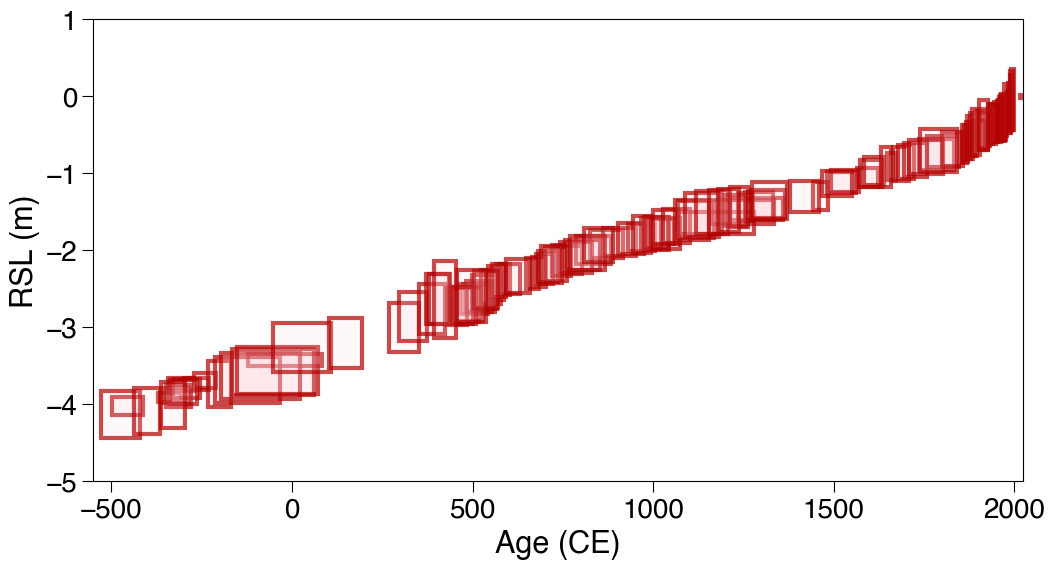

In [3]:
#load data 
X,y,y_sigma,x_sigma,lon,lat = PSTHM.load.load_local_rsl_data('../../Data/NJ_CC.csv',CE=True)

#visualize data
ax = PSTHM.plotting.plot_uncertainty_boxes(X,y, x_sigma*2,y_sigma*2,CE=True)
ax.set_xlim(-550,2025)
ax.set_ylim(-5,1)
plt.show();

We can identify from the data that RSL change in New Jersey is non-linear with a potential abrupt RSL rise after 1900s. Let's try to reveal the underlying sea-level change pattern and rate by different GP kernels. Before we start to introduce specific kernels, let's just have a first glance of how do they look like in 1D space. Again, don't worry about the code here. 


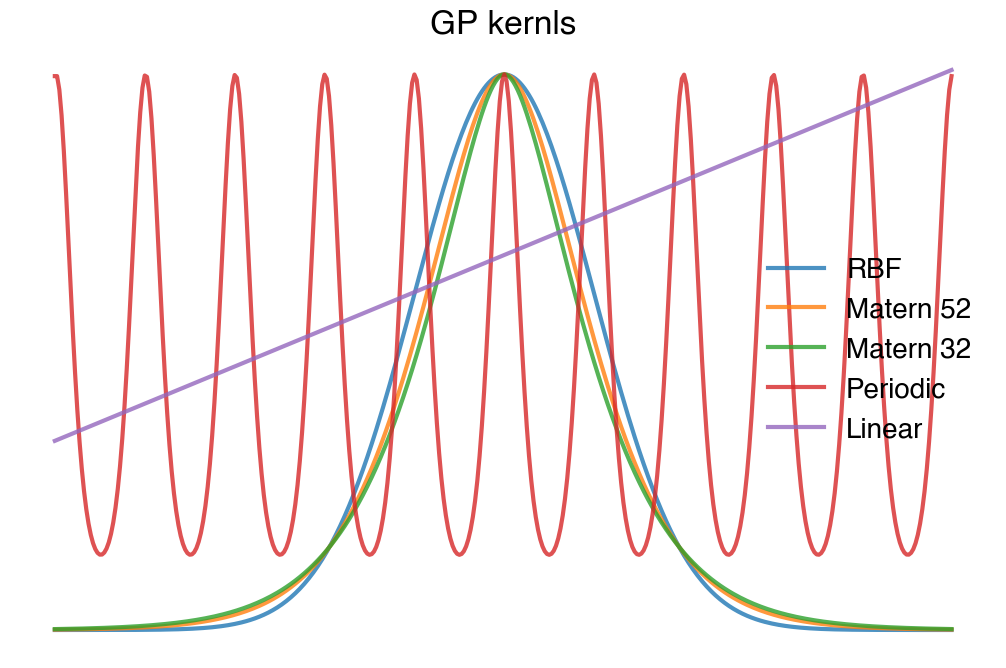

In [4]:
#build stationary GP kernels
pyro.clear_param_store()
RBF_kernel = PSTHM.kernels.RBF(input_dim=1,lengthscale=torch.tensor(1.0),variance=torch.tensor(1.0))
M52_kernel = PSTHM.kernels.Matern52(input_dim=1,lengthscale=torch.tensor(1.0),variance=torch.tensor(1.0))
M32_kernel = PSTHM.kernels.Matern32(input_dim=1,lengthscale=torch.tensor(1.0),variance=torch.tensor(1.0))
P_kernel = PSTHM.kernels.Periodic(input_dim=1,lengthscale=torch.tensor(1.0),variance=torch.tensor(1.0),period=torch.tensor(1.0))
L_kernel = PSTHM.kernels.Polynomial(input_dim=1,degree= 1, variance=torch.tensor(1.0))

#calculate covariance matrix
test_input = torch.linspace(5,15,400)
RBF_cov = RBF_kernel(test_input)[200]
M52_cov = M52_kernel(test_input)[200]
M32_cov = M32_kernel(test_input)[200]
P_cov = P_kernel(test_input)[200]
L_cov = L_kernel(test_input)[200]/150

#visualize covariance matrix
plt.figure(figsize=(28,8))
plt.subplot(121)
plt.plot(test_input,RBF_cov.detach().numpy(),label='RBF',lw=3,alpha=0.8)
# plt.plot(test_input,DP_cov.detach().numpy(),label='DP',lw=3,alpha=0.8)
plt.plot(test_input,M52_cov.detach().numpy(),label='Matern 52',lw=3,alpha=0.8)
plt.plot(test_input,M32_cov.detach().numpy(),label='Matern 32',lw=3,alpha=0.8)
plt.plot(test_input,P_cov.detach().numpy(),label='Periodic',lw=3,alpha=0.8)
plt.plot(test_input,L_cov.detach().numpy(),label='Linear',lw=3,alpha=0.8)
plt.legend()
plt.axis('off')
plt.title('GP kernls');




You will find there are two types of kernels: stationary and non-stationary kernels. A stationary kernel (all kernels except linear kernel) is one that only depends on the relative position of its two inputs, and not on their absolute location. On ther other hand, non-stationary kernel (linear kernel) depends on the absolute position of each data point, therefore it allows for the covariance structure to vary across different regions of the input space. For each type of kernel, there are more options, you can find a full list of kernel [here](https://docs.pyro.ai/en/stable/contrib.gp.html).  


**1.1 RBF kernel** 

The Radial Basis Function kernel (AKA Squared Exponential Kernel) is a default kernel choice for many applications due to several nice properties:  It is [universal](https://jmlr.csail.mit.edu/papers/volume7/micchelli06a/micchelli06a.pdf), and you can integrate it against most functions that you need to. Every function in its prior has infinitely many derivatives. It also has only two parameters:

$$
k_{RBF}(t,t') = \sigma^2\exp\left(-0.5 \times \frac{|t-t'|^2}{l^2}\right)
$$

where $\sigma ^2$ and $l$ are variance and lengthscale hyperparameters that control the overall amplitude and smoothness of the kernel function. You should be familiar with them from the last tutorial. 

A reminder that, to build a GP model with pyro and PaleoSTeHM, we should go through the following precedures:

* Clear parameter store: it is very important to clear all parameter store for every pyro model
* Build a GP kernel: we should define initial value or prior distributions for hyperparameters
* Build a GP model: we should set input dimension (which is 1 here), input varaible, output variable and observational noise
* Run GP model: this indicates we are calculating conditional probability given the observations and hyperparameters



  0%|          | 0/1000 [00:00<?, ?it/s]

Log Likelihood 163.452
Execution time: 1.631 s


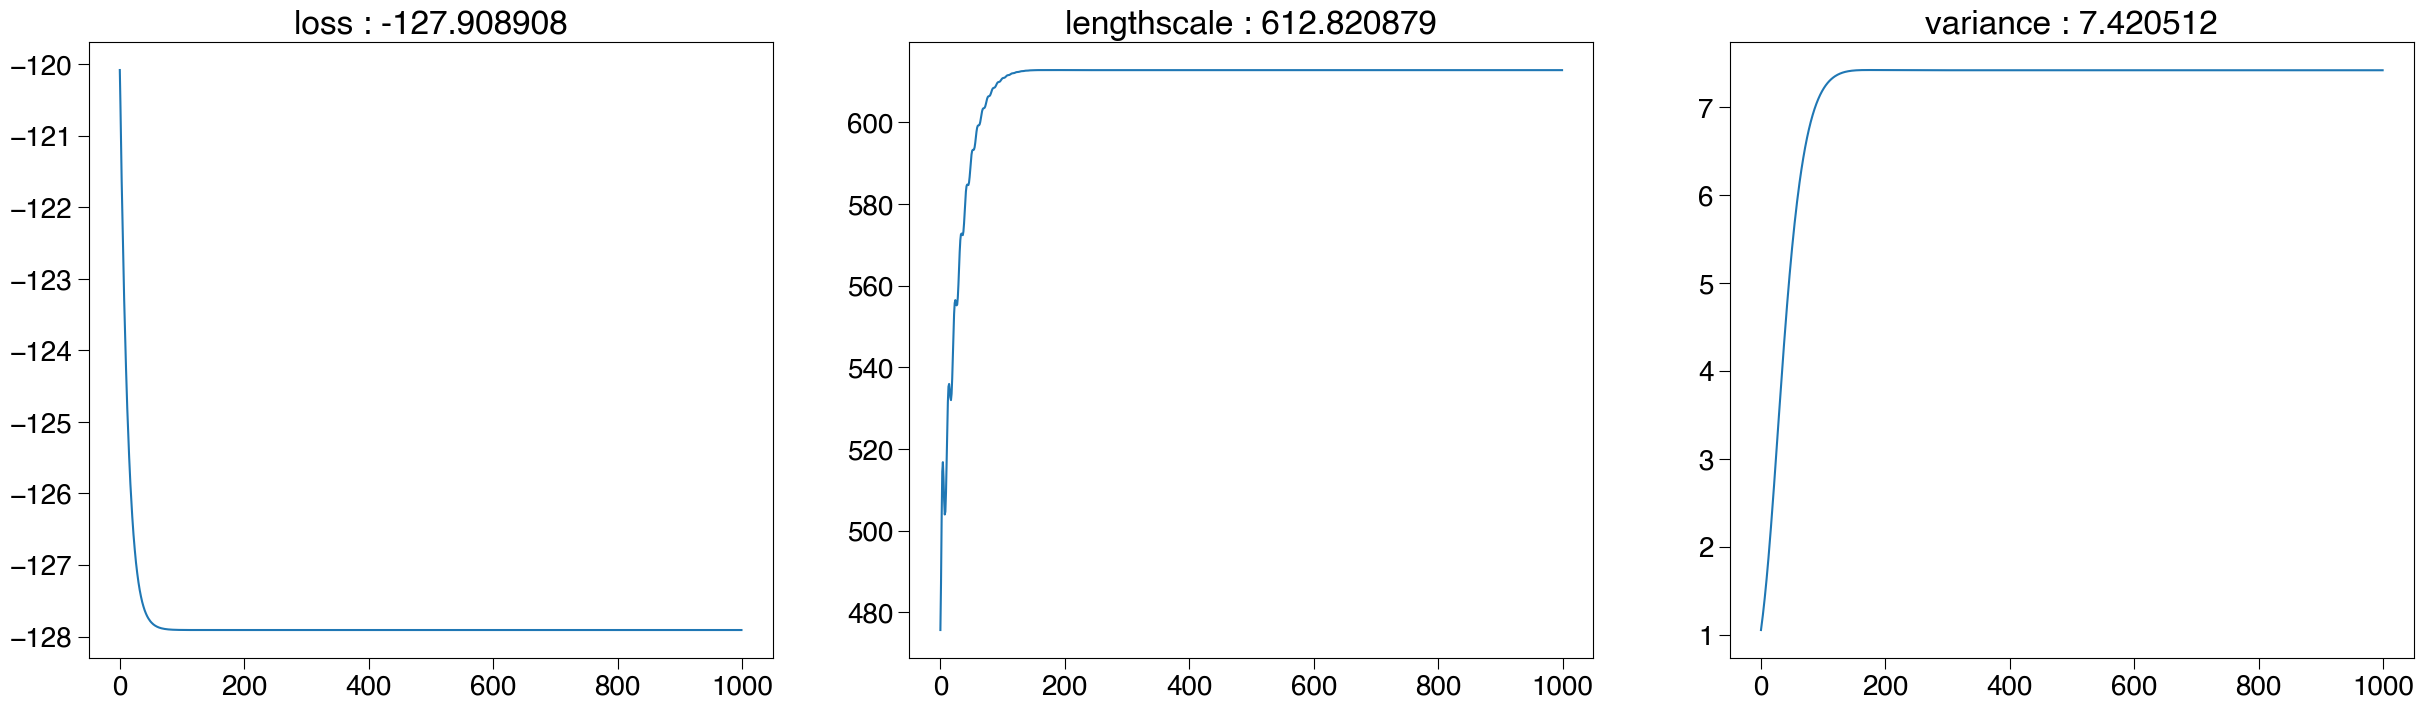

In [13]:
# calculate computational time
st = time.time() 

pyro.clear_param_store()

#generate a RBF kernel 
RBF_kernel = PSTHM.kernels.RBF(input_dim=1,variance=torch.tensor(1.),lengthscale=torch.tensor(500.))

#generate a GP gression model conditioned on RSL data
gpr = PSTHM.model.GPRegression_V(X, y, RBF_kernel,noise=torch.tensor(y_sigma**2),jitter=1e-5)

#Empirical bayes optimization, default iteration is 1000
gpr,track_list = PSTHM.opti.SVI_optm(gpr,num_iteration=1000)

#calulate log likelihood of the model prediction
pred_y,_ = gpr(X.double(), full_cov=True)

fit_likelihood = PSTHM.post.cal_likelihood(y.detach().numpy(),y_sigma.detach().numpy(),pred_y.detach().numpy())
print('Log Likelihood {:3.3f}'.format(fit_likelihood))

axes = PSTHM.plotting.plot_track_list(track_list)

et = time.time() # get the end time

# get the execution time
elapsed_time = et - st
print('Execution time: {:3.3f} s'.format( elapsed_time))


To compare different kernels performance, we print the log likelihood along with the loss function and hyperparameter training plot. A higher the log likelihood function will indicate a better model fit to the data.

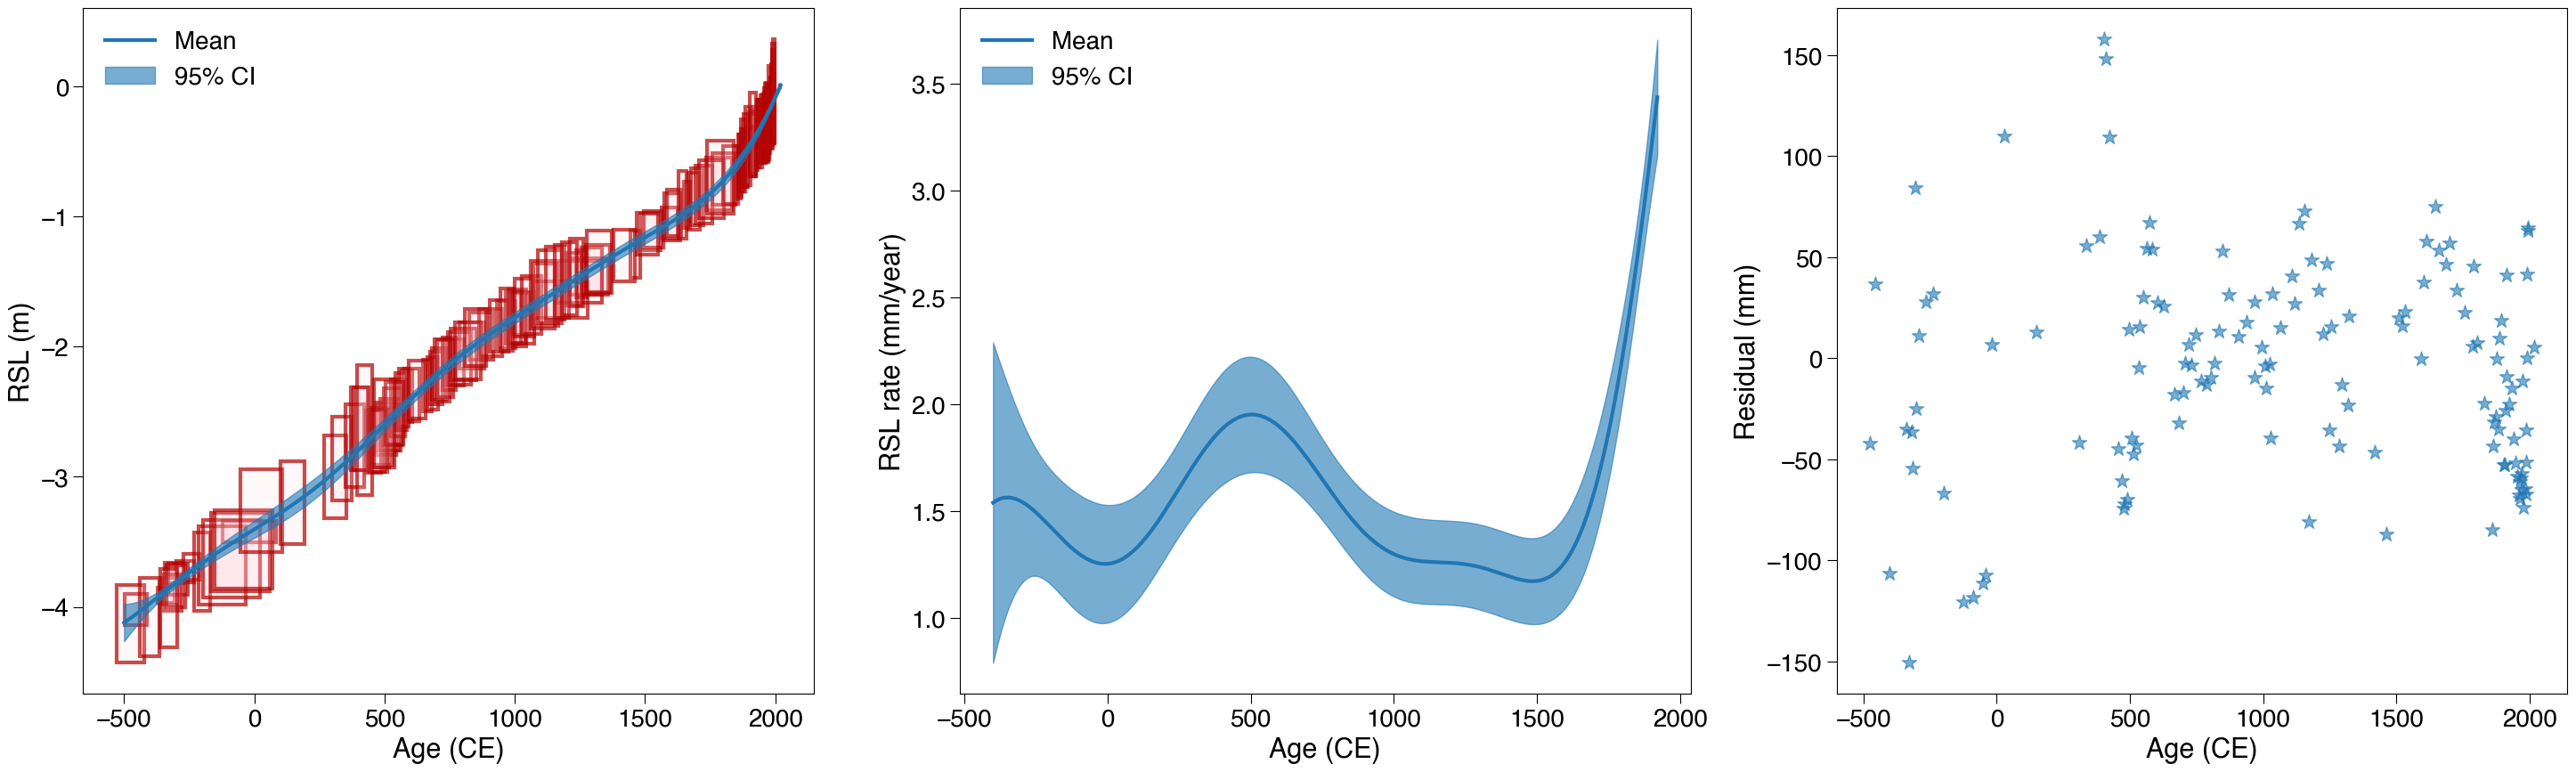

In [14]:
# Make predictions on new inputs
x_test = torch.arange(-500,2025,5.)
y_mean, y_var = gpr(x_test.double(), full_cov=True,noiseless=True)
sd = torch.diag(y_var).sqrt()  # standard deviation at each input point x
rsl_time,rsl_rate,rsl_rate_sd = PSTHM.post.cal_rate_var(x_test.detach().numpy(),y_var.detach().numpy(),y_mean.detach().numpy())

axes = PSTHM.plotting.plot_tem_regression(X,y,x_sigma,y_sigma,x_test,y_mean,sd,
                          rsl_time,rsl_rate,rsl_rate_sd)

You can see that the inference results by a RBF kernel is really smooth, this is due to its property of infinitely differentiable. This property is mostly ok in many cases, but it may not be appropriate for a time series that may change abruptly sometimes, like sea-level rise caused by global warming. In this case, let's introduce two alternative kernels that relif the infinitely differentiable assumption.

**1.2 3/2 Matérn kernel**

The Matérn family of kernels were popularized by Michael Stein, who coined the name based on initial work by statistician Bertil Matérn. Within Matérn family, each kernel has a $\nu$ parameter, indicating that kernel is $\nu$ - 0.5 times differentiable. For example, 3/2 Matérn kernel has a $\nu$ value of 3/2, which can be expressed as:

$$
k_{M_{32}}(t, t') = \sigma^2\left(1 + \sqrt{3} \times \frac{|t-t'|}{l}\right)
        \exp\left(-\sqrt{3} \times \frac{|t-t'|}{l}\right)
$$
therefore, 3/2 Matérn kernel is one-time differentiable. Similar to RBF kernel, $\sigma$ here is an amplitude hyperparameter and $l$ is a length scale hyperparameter. $|t-t'|$ indicate a abosolute distance matrix, which only differs squared distance function we introduced in last tutorial because it uses the abosolute distance. Since 3/2 Matérn kernel is only once differentiable, it allows sea-level to change more abruptly.



  0%|          | 0/1000 [00:00<?, ?it/s]

Log Likelihood 165.505
Execution time: 1.721 s


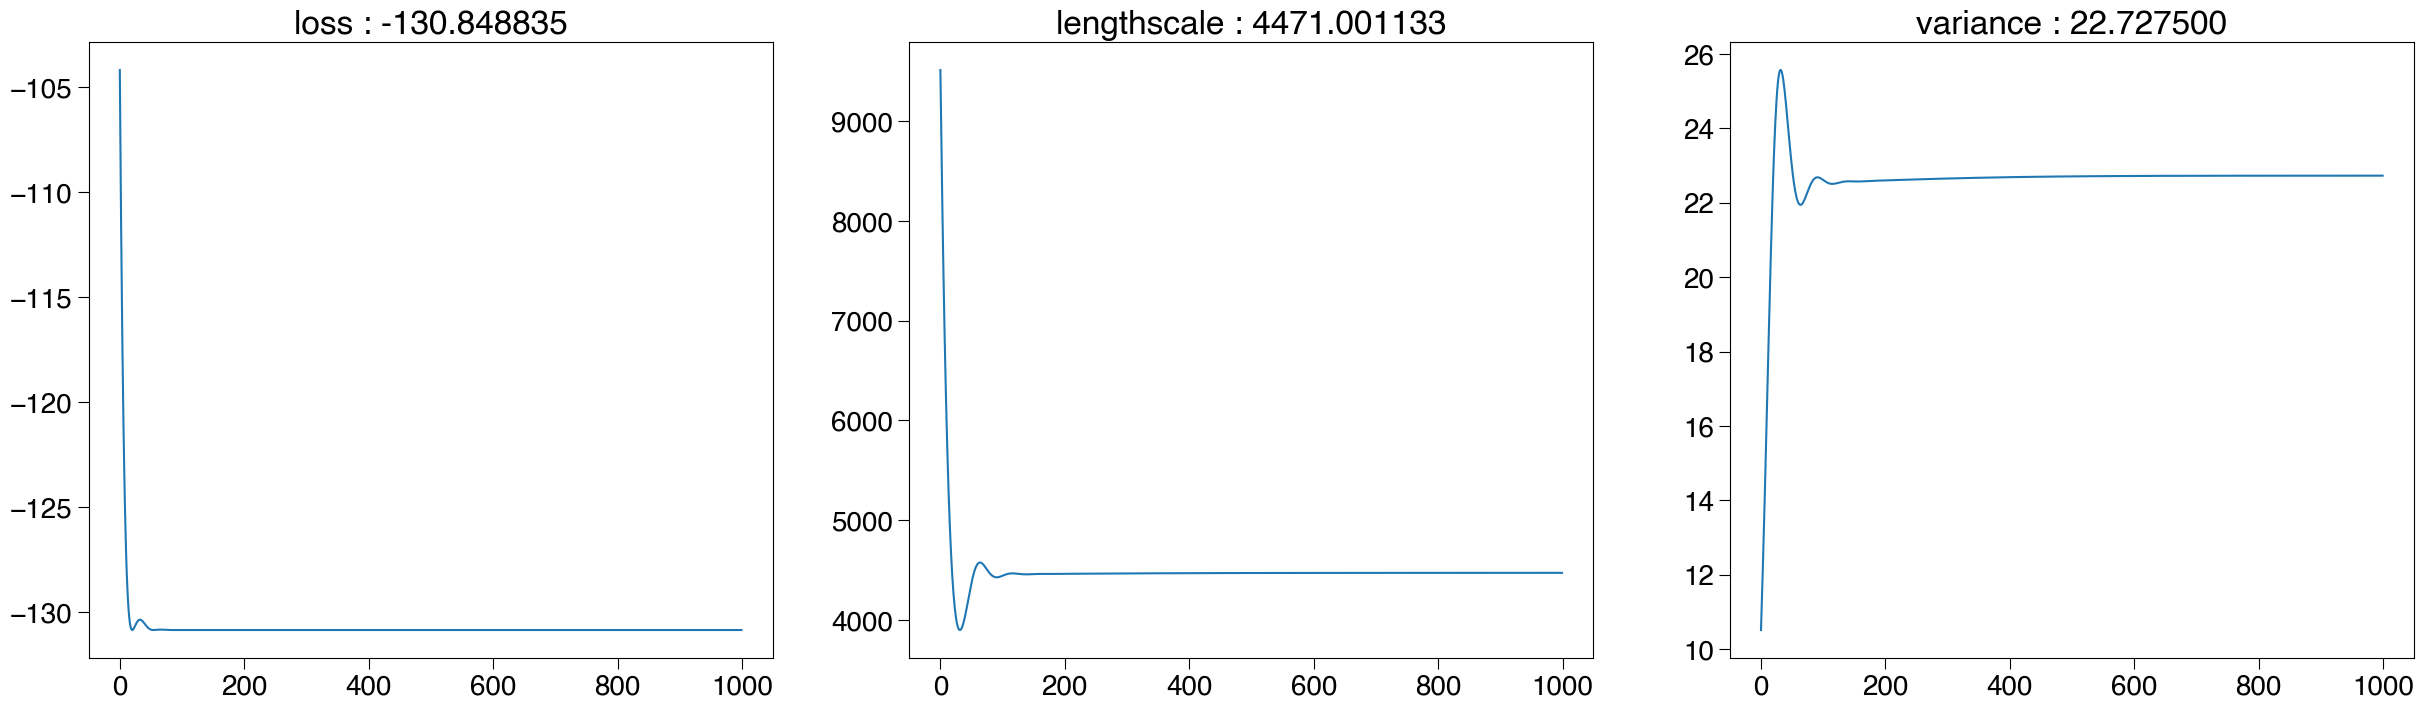

In [16]:
# calculate computational time
st = time.time() 

pyro.clear_param_store()

#generate a Matern32 kernel 
Matern32_kernel = PSTHM.kernels.Matern32(input_dim=1,variance=torch.tensor(10.),lengthscale=torch.tensor(10000.))

#generate a GP gression model conditioned on RSL data
gpr = PSTHM.model.GPRegression_V(X, y, Matern32_kernel,noise=torch.tensor(y_sigma**2),jitter=1e-5)

#Empirical bayes optimization, default iteration is 1000
gpr,track_list = PSTHM.opti.SVI_optm(gpr,num_iteration=1000)

#calulate log likelihood of the model prediction
pred_y,_ = gpr(X.double(), full_cov=True)

fit_likelihood = PSTHM.post.cal_likelihood(y.detach().numpy(),y_sigma.detach().numpy(),pred_y.detach().numpy())
print('Log Likelihood {:3.3f}'.format(fit_likelihood))
axes = PSTHM.plotting.plot_track_list(track_list)

et = time.time() # get the end time

# get the execution time
elapsed_time = et - st
print('Execution time: {:3.3f} s'.format( elapsed_time))

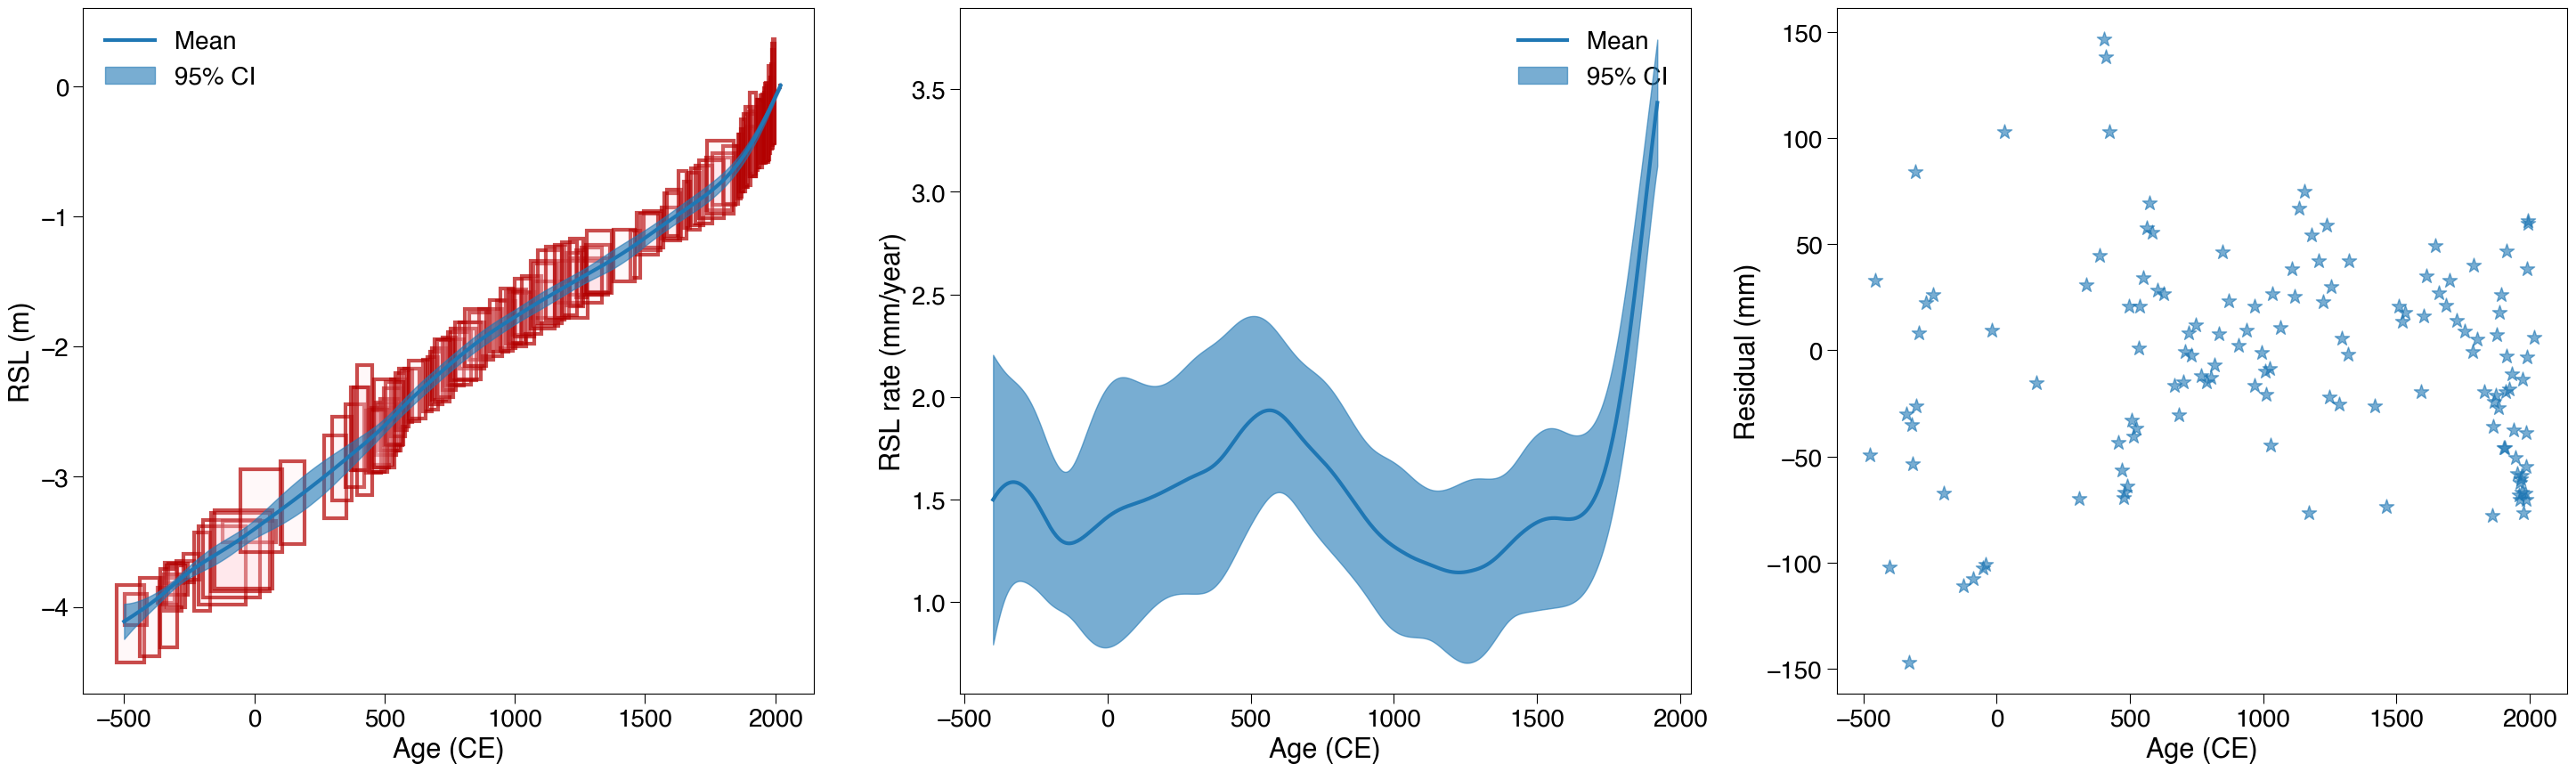

In [17]:
# Make predictions on new inputs
x_test = torch.arange(-500,2025,5.,requires_grad=True)
Matern32_y_mean, Matern32_y_var = gpr(x_test.double(), full_cov=True,noiseless=True)
Matern32_sd = torch.diag(Matern32_y_var).sqrt()  # standard deviation at each input point x
rsl_time,Matern32_rsl_rate,Matern32_rsl_rate_sd = PSTHM.post.cal_rate_var(x_test.detach().numpy(),Matern32_y_var.detach().numpy(),Matern32_y_mean.detach().numpy())

axes = PSTHM.plotting.plot_tem_regression(X,y,x_sigma,y_sigma,x_test,Matern32_y_mean,Matern32_sd,
                          rsl_time,Matern32_rsl_rate,Matern32_rsl_rate_sd)

You can see that 3/2 Matérn kernel is able to capture more short-wavelength information and shows higher log likelihood compared with RBF kernel!

**1.3 5/2 Matérn kernel**

And if we think the signal might change abruptly but not as much as indicated by 3/2 Matérn kernel, we have an intermideate option of 5/2 Matérn kernel, which is two-times differentiable. This kernel is useful and commonly-used in spatio-temporal analysis which we will cover in another tutorial. This kernel can be written as:
$$
k_{M_{52}}(t,t')=\sigma^2\left(1+\sqrt{5}\times\frac{|t,t'|}{l}+\frac{5}{3}\times
        \frac{|t,t'|^2}{l^2}\right)\exp\left(-\sqrt{5} \times \frac{|t,t'|}{l}\right)
$$
As above, $\sigma$ here is an amplitude hyperparameter and $l$ is a length scale hyperparameter.

  0%|          | 0/1000 [00:00<?, ?it/s]

Log Likelihood 163.702
Execution time: 1.820 s


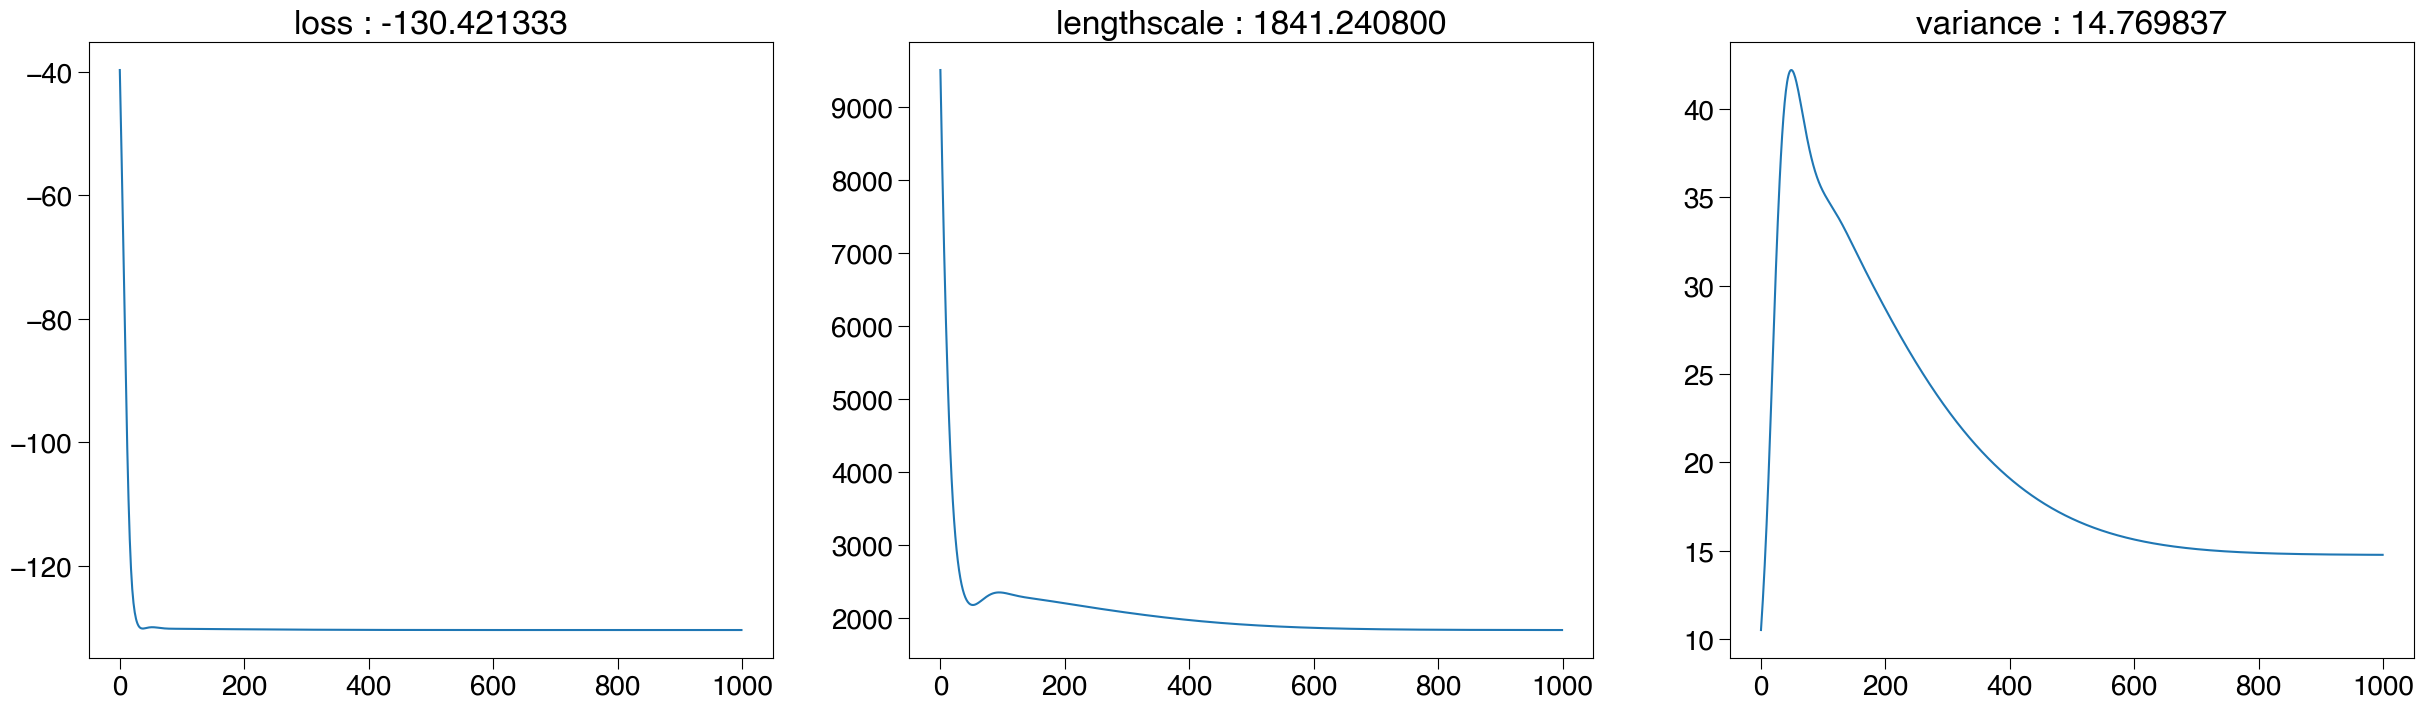

In [20]:
# calculate computational time
st = time.time() 

pyro.clear_param_store()

#generate a Matern52 kernel 
Matern52_kernel = PSTHM.kernels.Matern52(input_dim=1,variance=torch.tensor(10.),lengthscale=torch.tensor(10000.))

#generate a GP gression model conditioned on RSL data
gpr = PSTHM.model.GPRegression_V(X, y, Matern52_kernel,noise=torch.tensor(y_sigma**2),jitter=1e-5)

#Empirical bayes optimization, default iteration is 1000
gpr,track_list = PSTHM.opti.SVI_optm(gpr,num_iteration=1000)

#calulate log likelihood of the model prediction
pred_y,_ = gpr(X.double(), full_cov=True)

fit_likelihood = PSTHM.post.cal_likelihood(y.detach().numpy(),y_sigma.detach().numpy(),pred_y.detach().numpy())
print('Log Likelihood {:3.3f}'.format(fit_likelihood))
axes = PSTHM.plotting.plot_track_list(track_list)

et = time.time() # get the end time

# get the execution time
elapsed_time = et - st
print('Execution time: {:3.3f} s'.format( elapsed_time))

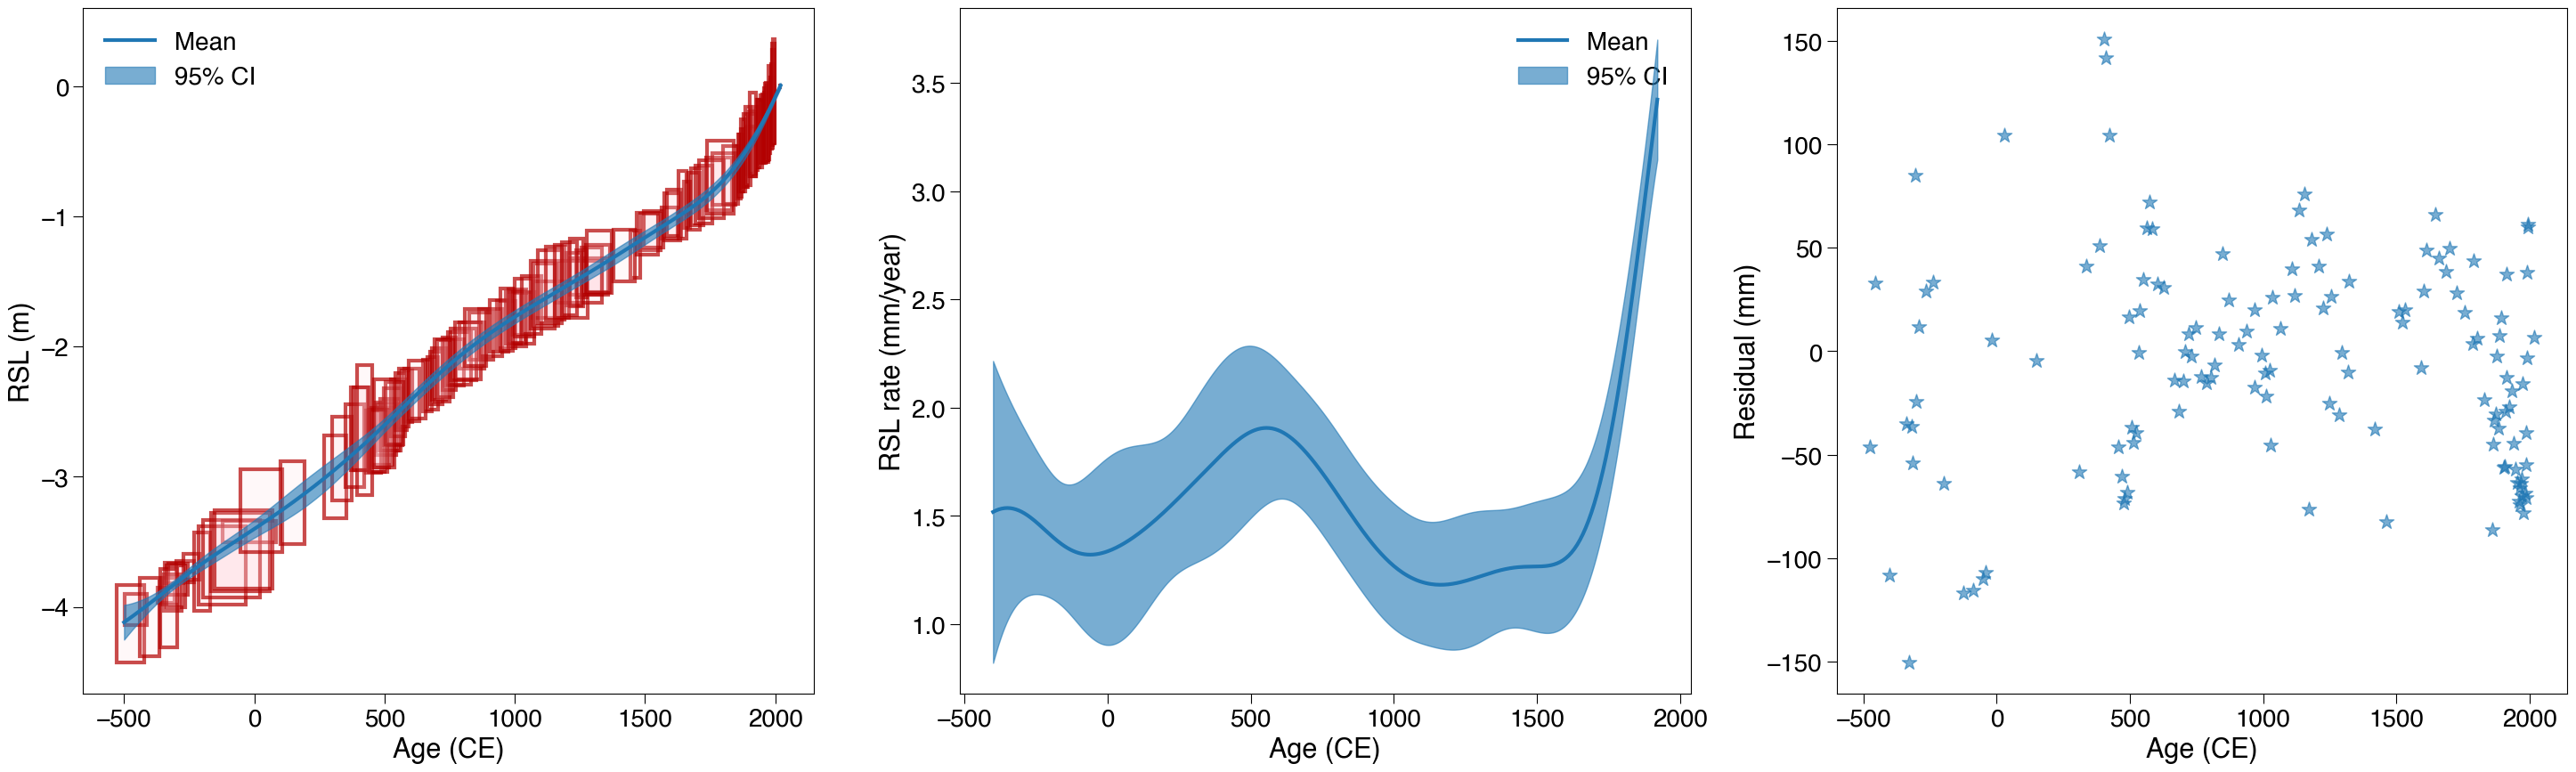

In [21]:
# Make predictions on new inputs
x_test = torch.arange(-500,2025,5.,requires_grad=True)
Matern52_y_mean, Matern52_y_var = gpr(x_test.double(), full_cov=True,noiseless=True)
Matern52_sd = torch.diag(Matern52_y_var).sqrt()  # standard deviation at each input point x
rsl_time,Matern52_rsl_rate,Matern52_rsl_rate_sd = PSTHM.post.cal_rate_var(x_test.detach().numpy(),Matern52_y_var.detach().numpy(),Matern52_y_mean.detach().numpy())

axes = PSTHM.plotting.plot_tem_regression(X,y,x_sigma,y_sigma,x_test,Matern52_y_mean,Matern52_sd,
                          rsl_time,Matern52_rsl_rate,Matern52_rsl_rate_sd)

We can see that, the predictions by 5/2 Matérn kernel is somehow intermidiate between RBF and 3/2 Matérn kernel with an intermediate log-likelihood. If you wish to make this inference even more smoother, you can use [7/2, 9/2 Matérn kernels](https://en.wikipedia.org/wiki/Mat%C3%A9rn_covariance_function), and when the $\nu$ parameter becomes infinite, Matérn kernel becomes the same as RBF kernel. 

**1.4 Periodic Kernel**

Ok, up to now we are working for long-term sea-level change data across thousands of years, but if we work for short-term sea-level data with hourly resolution, we might expect the tide to go up and down. In other words, it has some periodicity we want to capture and we want to see those periodicity even for future when we do not observations. This is when Periodic Kernel becomes useful:
$$
k_{Periodic}(t,t')=\sigma^2\exp\left(-2\times\frac{\sin^2(\pi(t,t')/p)}{l^2}\right)
$$
As above, $\sigma$ here is an amplitude hyperparameter and $l$ is a length scale hyperparameter and $p$ is a periodicity parameter which controls the output periodicity. To better illustrate this kernel, we use a synthetic sine wave data.

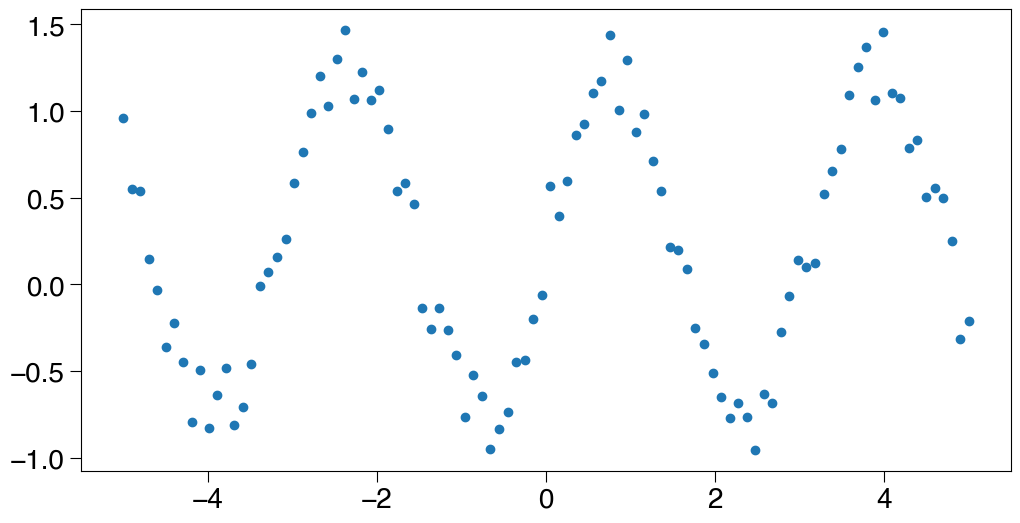

In [4]:
#generate synthetic data
syn_X = torch.linspace(-5, 5, 100)
syn_y = torch.sin(syn_X *2)+torch.rand_like(syn_X) * 0.5
plt.scatter(syn_X, syn_y)
plt.show()

  0%|          | 0/2000 [00:00<?, ?it/s]

Execution time: 2.958 s


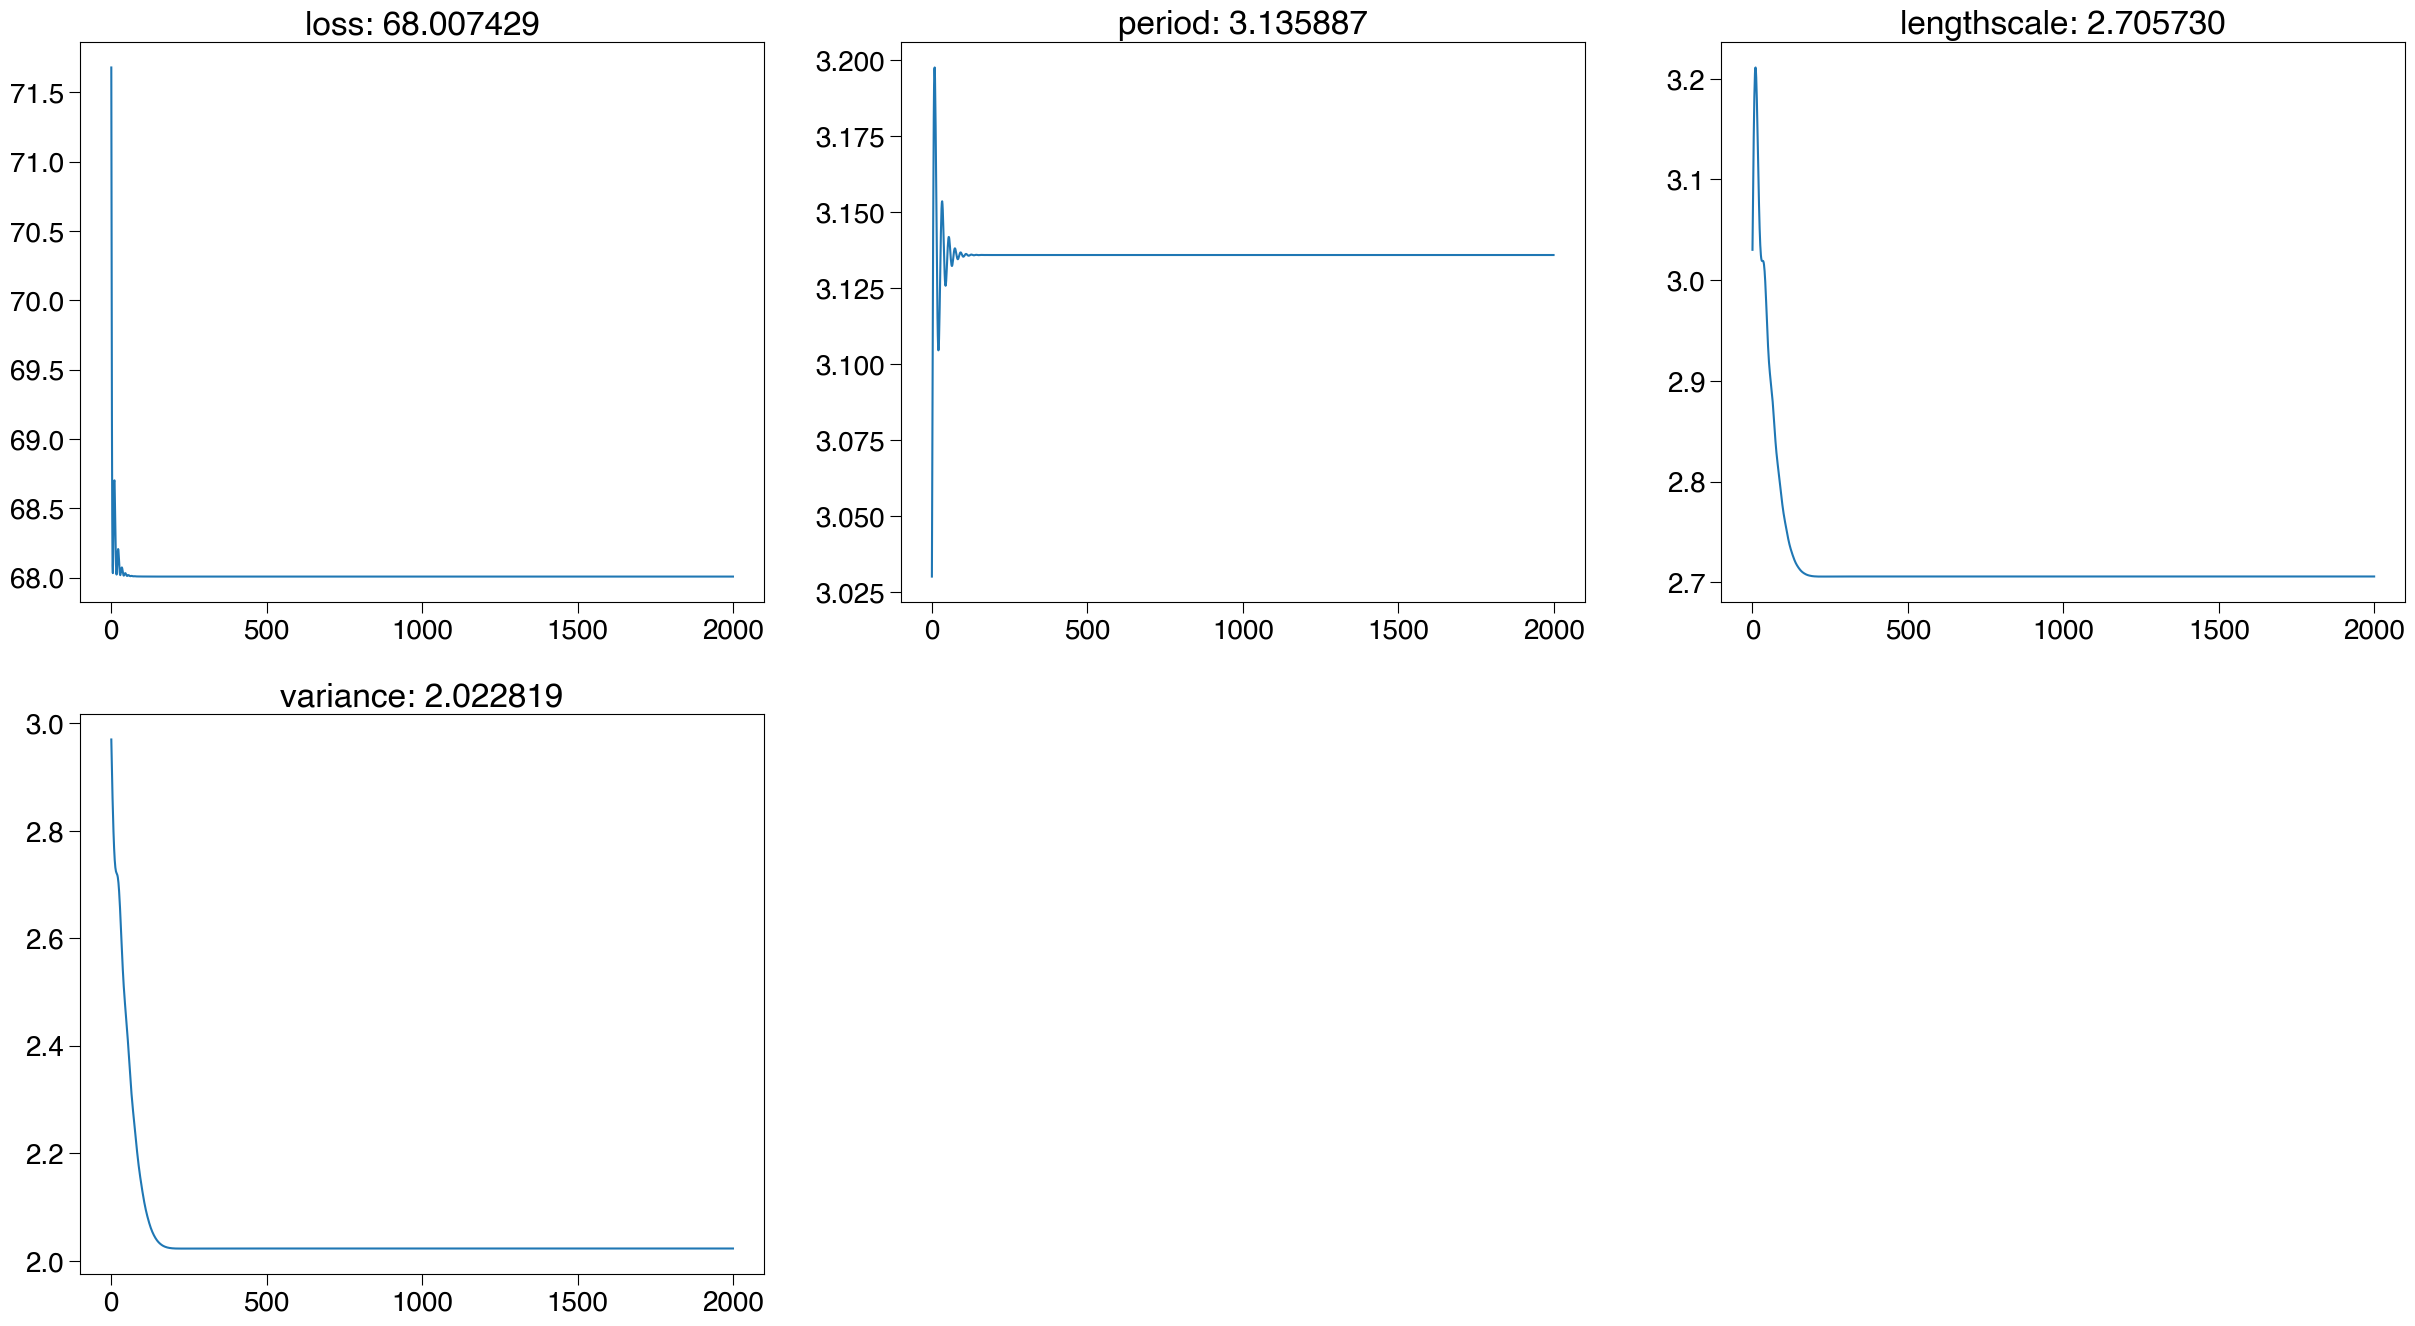

In [12]:
# calculate computational time
st = time.time() 

pyro.clear_param_store()

#generate a Matern52 kernel 
P_kernel = PSTHM.kernels.Periodic(input_dim=1,variance=torch.tensor(3.),lengthscale=torch.tensor(3.),period=torch.tensor(3.))

#generate a GP gression model conditioned on RSL data
gpr = PSTHM.model.GPRegression_V(syn_X, syn_y, P_kernel,noise=torch.ones(len(syn_X))*0.5,jitter=1e-5)

#Empirical bayes optimization, default iteration is 1000
gpr,track_list = PSTHM.opti.SVI_optm(gpr,num_iteration=2000,lr=0.01)

axes = PSTHM.plotting.plot_track_list(track_list)

et = time.time() # get the end time

# get the execution time
elapsed_time = et - st
print('Execution time: {:3.3f} s'.format( elapsed_time))

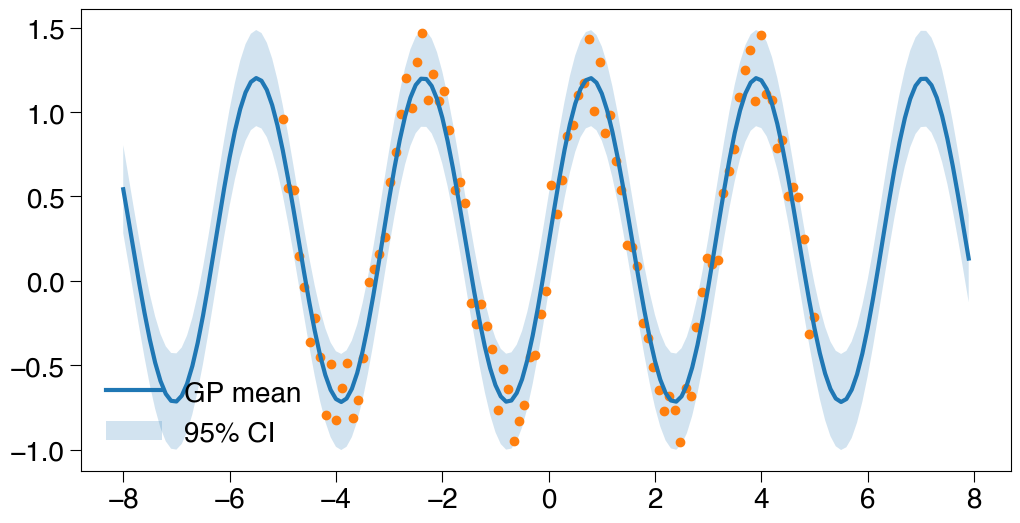

In [7]:
# Make predictions on new inputs
x_test = torch.arange(-8,8,0.1,requires_grad=True)
P_y_mean, P_y_var = gpr(x_test.double(), full_cov=True,noiseless=True)
P_sd = torch.diag(P_y_var).sqrt()  # standard deviation at each input point x
rsl_time,P_rsl_rate,P_rsl_rate_sd = PSTHM.post.cal_rate_var(x_test.detach().numpy(),P_y_var.detach().numpy(),P_y_mean.detach().numpy()
                                                       ,difftimestep=1)

plt.plot(x_test.detach().numpy(),P_y_mean.detach().numpy(),lw=3,label='GP mean ')
plt.fill_between(x_test.detach().numpy(),P_y_mean.detach().numpy()-2*P_sd.detach().numpy(),
                    P_y_mean.detach().numpy()+2*P_sd.detach().numpy(),alpha=0.2,label='95% CI')
plt.scatter(syn_X, syn_y)
plt.legend()
plt.show()

Instead of gradually decay to GP mean value, periodic kernel will continue its periodcity to locations where there is no data. And if we see the optimized periodcity parameter, it well reflects the sine wave periodcity. 

**1.5 Linear Kernel**

Unlike stationary kernels above, linear kernel is a non-stationary kernel allows the covariance structure to vary across different regions of the input space. It therefore can capture varying patterns and trends in the data. A linear kernel can be written as:
$$
k_{Linear}(t,t') = \sigma^2(\text{bias} + t \cdot t')
$$
where $\sigma$ is a hyperparameter that determines the rate of this linear model. The bias hyperparameter determines the x-coordinate of the point that all the lines in the posterior go though. At this point, the function will have zero variance. Performing GP with a linear kernel is esstential the same as doing Bayesian linear regression.  


  0%|          | 0/1000 [00:00<?, ?it/s]

Log Likelihood 7.036
Execution time: 1.457 s


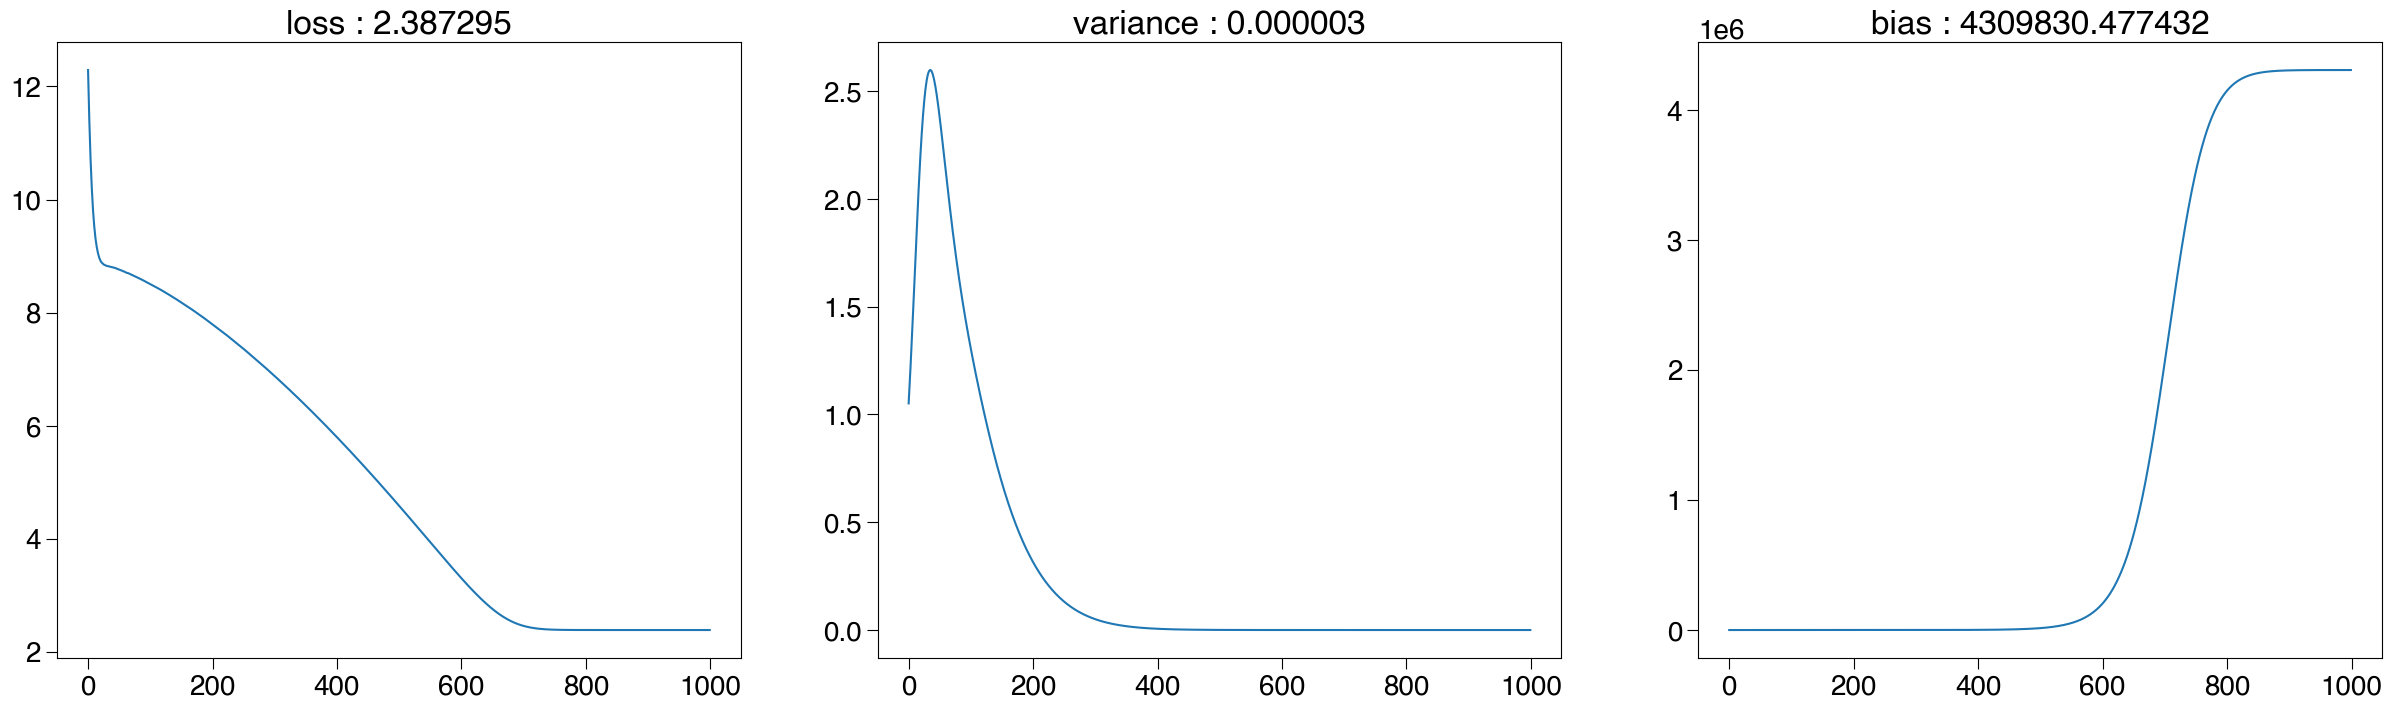

In [13]:
st = time.time() 

pyro.clear_param_store()

#generate a Linear kernel, note degree 1 polynomial kernel is a linear kernel 
Linear_kernel = PSTHM.kernels.Polynomial(input_dim=1,degree=1,bias=torch.tensor(1.),variance=torch.tensor(1.))

#generate a GP gression model conditioned on RSL data
gpr = PSTHM.model.GPRegression_V(X, y, Linear_kernel,noise=torch.tensor(y_sigma**2),jitter=1e-5)

#Empirical bayes optimization, default iteration is 1000
gpr,track_list = PSTHM.opti.SVI_optm(gpr,num_iteration=1000)

#predict RSL for each rsl data age 
pred_y,_ = gpr(gpr.X, full_cov=True) 

#calulate log likelihood of the model prediction
fit_likelihood = PSTHM.post.cal_likelihood(y.detach().numpy(),y_sigma.detach().numpy(),pred_y.detach().numpy())
print('Log Likelihood {:3.3f}'.format(fit_likelihood))
axes = PSTHM.plotting.plot_track_list(track_list)
et = time.time() # get the end time

# get the execution time
elapsed_time = et - st
print('Execution time: {:3.3f} s'.format( elapsed_time))

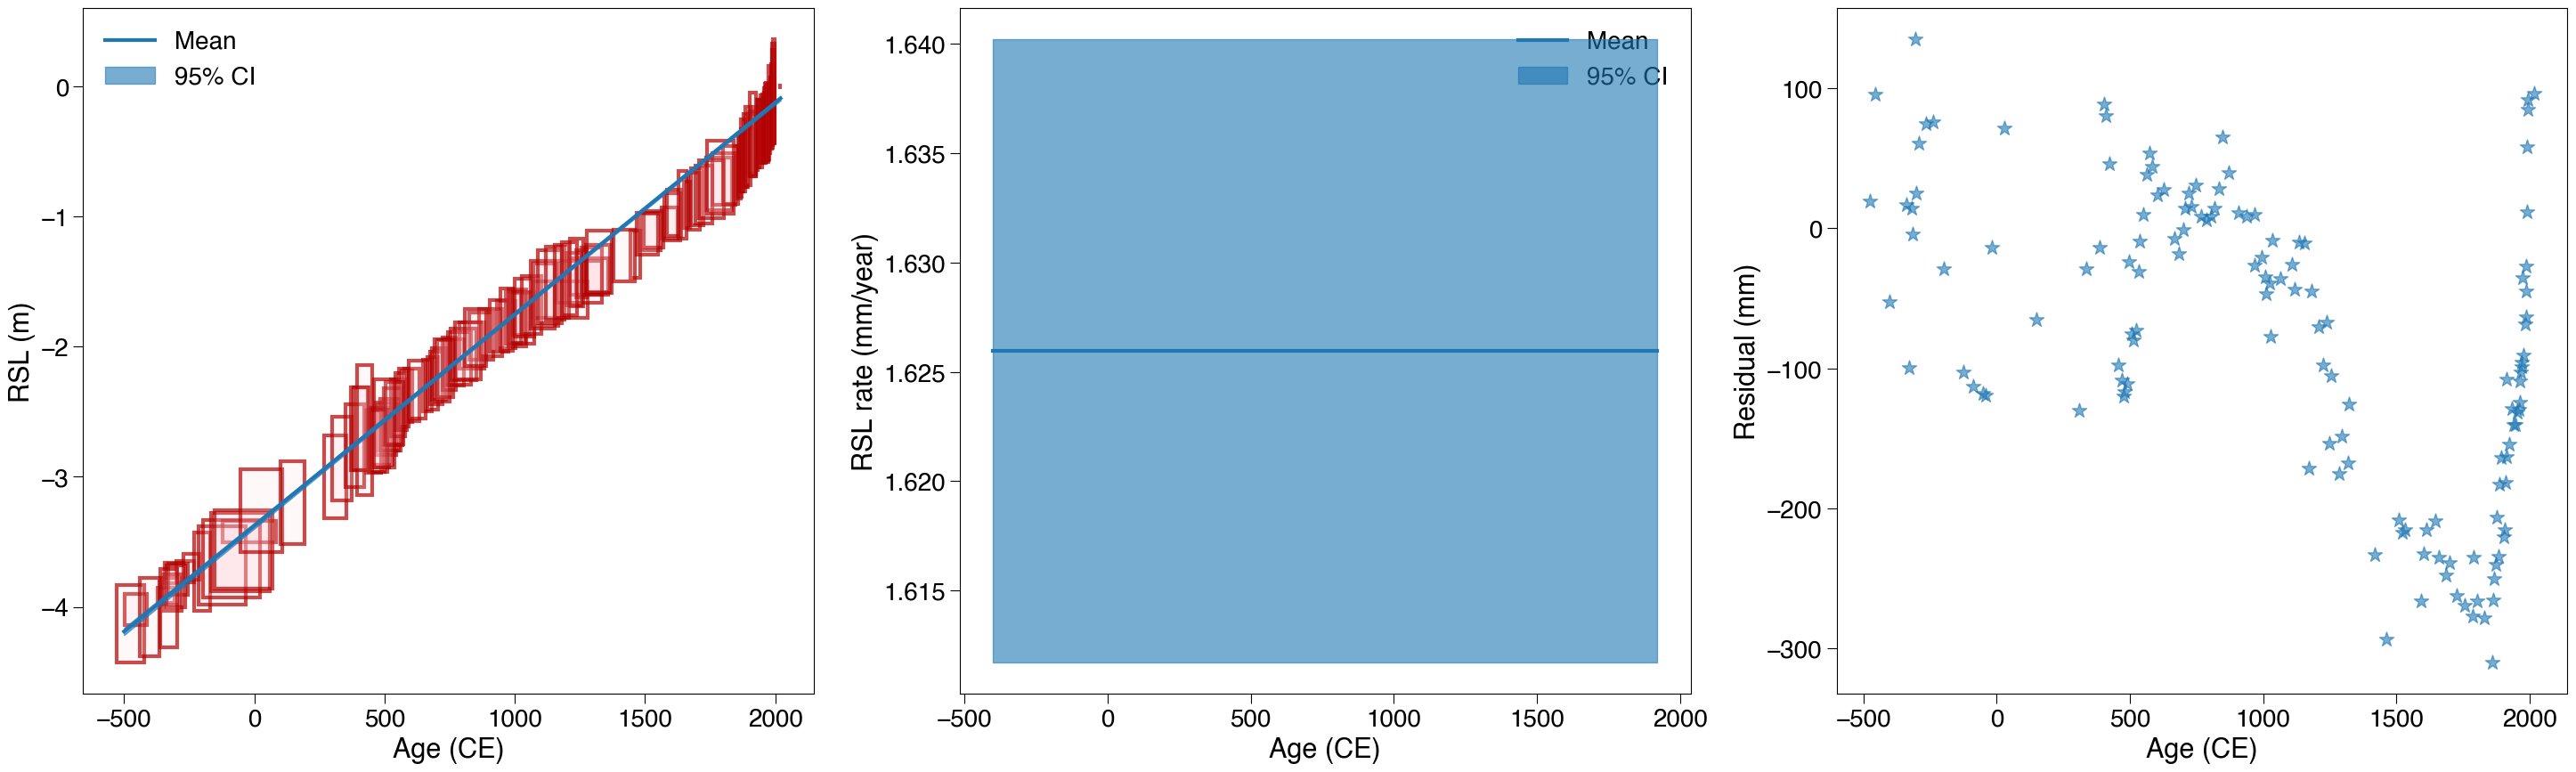

In [15]:
# Make predictions on new inputs
x_test = torch.arange(-500,2025,5.).double()
y_mean, y_var = gpr(x_test, full_cov=True,noiseless=True)
sd = torch.diag(y_var).sqrt()  # standard deviation at each input point x
rsl_time,rsl_rate,rsl_rate_sd = PSTHM.post.cal_rate_var(x_test.detach().numpy(),y_var.detach().numpy(),y_mean.detach().numpy())

axes = PSTHM.plotting.plot_tem_regression(X,y,x_sigma,y_sigma,x_test,y_mean,sd,
                          rsl_time,rsl_rate,rsl_rate_sd)

The linear kernel did a fairly good job on fitting the data, and it tells us sea-level rise rate in New Jersey from -500 CE to present is around 1.626 mm/yr. But if we look at the residual distribution, we can easily find some temporal structures, combining which with a low log-likelihood value indicats this linear model fails to capture some temporal variations of sea-level change process here. Indeed, a linear kernel maynot be able to capture underlying signal in most of the cases, but it is useful since we can combine it with other kernels, so it can help us to capture the linear sub-signal (e.g., caused by postglacial rebound). 

### 2. Combining different GP kernels

For environmental problems, there are many cases where a single kernel cannot capture all underlying physical processes. For example, if we look real-world yearly local sea-level data, we should see more than more physical processes including seasonal variability, long-term global sea-level rise and some local noisy signal due to sediment compaction or anthropogenic operations like groundwater extraction. 

**2.1 Summing two kernels**

Here's how combining different GP kernels work. We know that GP is controlled by mean and covariance function, and if we assume a 0 mean function, it only controls by the covariance function. But instead of using only one covariance function, we can use multiple, for example, we can sum two kernels into to get a combined kernel with combined property of each kernel
$$
k_{Combined}(t,t') = k_{Periodic}(t,t') + k_{Linear}(t,t')
$$


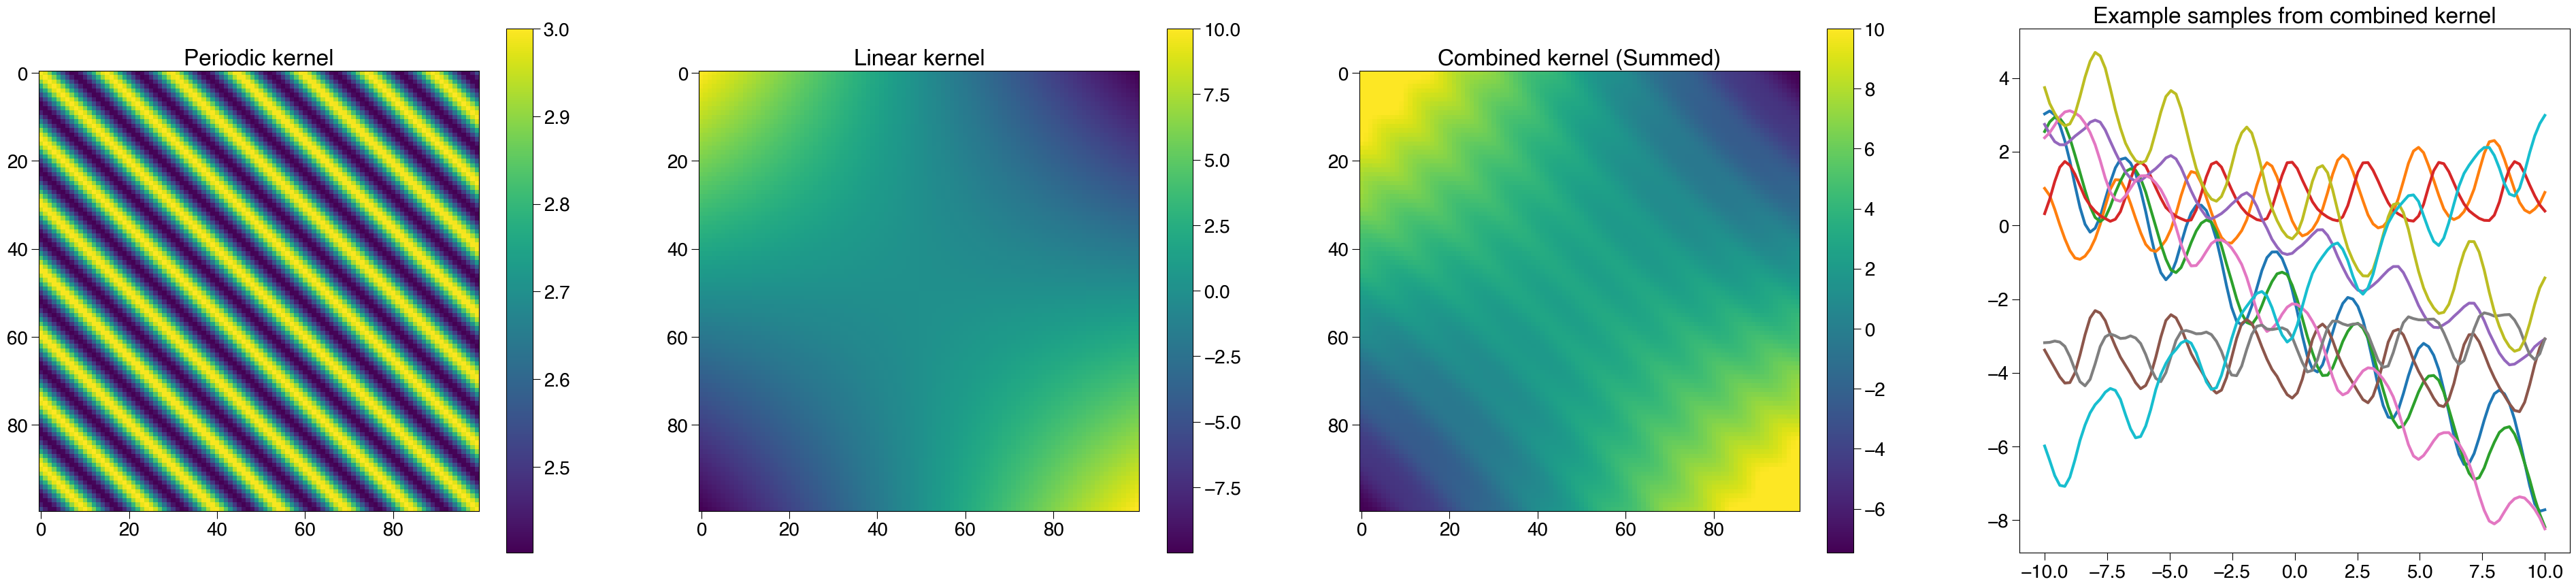

In [6]:
pyro.clear_param_store()
#build a periodic kernel
P_kernel = PSTHM.kernels.Periodic(input_dim=1,variance=torch.tensor(3.),lengthscale=torch.tensor(3.),period=torch.tensor(3.))
#build a linear kernel 
Linear_kernel = PSTHM.kernels.Polynomial(input_dim=1,degree=1,bias=torch.tensor(0),variance=torch.tensor(0.1))
#combine kernels
Combined_kernel = PSTHM.kernels.Sum(Linear_kernel,P_kernel)

#calculate the covariance matrix
test_x = torch.linspace(-10,10,100)
P = P_kernel(test_x).detach().numpy()
L = Linear_kernel(test_x).detach().numpy()
K = Combined_kernel(test_x)

#draw samples from combined kernel 

#draw sample from a multivariate normal distribution using covariance matrix above
#add a small number to the diagonal of the covariance matrix to make it positive definite
K += + (torch.ones(len(test_x))*1e-4).diag() 
samples = dist.MultivariateNormal(
            torch.zeros(len(test_x)), covariance_matrix=K
        ).sample(sample_shape=(10,))

plt.figure(figsize=(48,10))

plt.subplot(1,4,1)
plt.imshow(P)
plt.title('Periodic kernel')
plt.colorbar()

plt.subplot(1,4,2)
plt.imshow(L,vmax=10)
plt.title('Linear kernel')
plt.colorbar()

plt.subplot(1,4,3)
plt.imshow(K.detach().numpy(),vmax=10)
plt.title('Combined kernel (Summed)')
plt.colorbar()
plt.subplot(1,4,4)
for i in range(10):
    plt.plot(test_x,samples[i,:].detach().numpy(),lw=3)
plt.title('Example samples from combined kernel');

**2.2 Multiplying two kernels**

Other than summing two kernels together, we can multiply two kernels for a new combined kernel. This is very important for spatio-temporal GP which we will cover in next tutorial series. This process can be written as:
$$
k_{Combined_2}(t,t') = k_{Periodic}(t,t') \cdot k_{Linear}(t,t')
$$
where '$\cdot$' indicates element wise multiplication instead of matrix multiplication. 


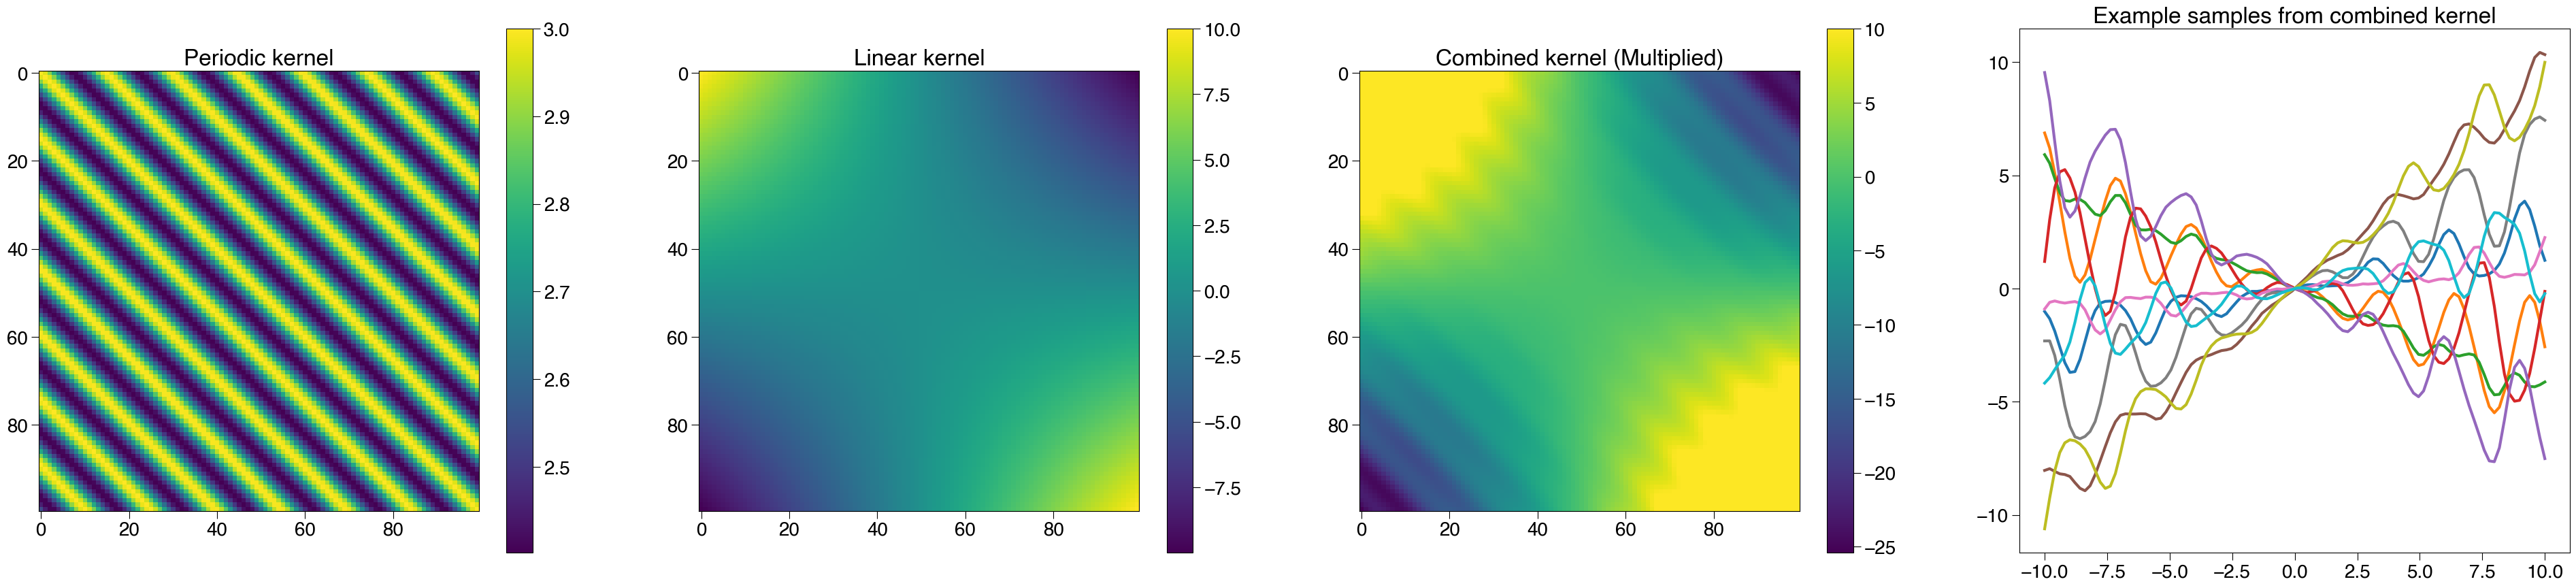

In [7]:
pyro.clear_param_store()
#build a periodic kernel
P_kernel = PSTHM.kernels.Periodic(input_dim=1,variance=torch.tensor(3.),lengthscale=torch.tensor(3.),period=torch.tensor(3.))
#build a linear kernel 
Linear_kernel = PSTHM.kernels.Polynomial(input_dim=1,degree=1,bias=torch.tensor(0),variance=torch.tensor(0.1))
#combine kernels
Combined_kernel2 = PSTHM.kernels.Product(Linear_kernel,P_kernel)

#calculate the covariance matrix
test_x = torch.linspace(-10,10,100)
P = P_kernel(test_x).detach().numpy()
L = Linear_kernel(test_x).detach().numpy()
K2 = Combined_kernel2(test_x)

#draw samples from combined kernel 

#draw sample from a multivariate normal distribution using covariance matrix above
#add a small number to the diagonal of the covariance matrix to make it positive definite
K2 += + (torch.ones(len(test_x))*1e-4).diag() 
samples2 = dist.MultivariateNormal(
            torch.zeros(len(test_x)), covariance_matrix=K2
        ).sample(sample_shape=(10,))

plt.figure(figsize=(48,10))

plt.subplot(1,4,1)
plt.imshow(P)
plt.title('Periodic kernel')
plt.colorbar()

plt.subplot(1,4,2)
plt.imshow(L,vmax=10)
plt.title('Linear kernel')
plt.colorbar()

plt.subplot(1,4,3)
plt.imshow(K2.detach().numpy(),vmax=10)
plt.title('Combined kernel (Multiplied)')
plt.colorbar()

plt.subplot(1,4,4)
for i in range(10):
    plt.plot(test_x,samples2[i,:].detach().numpy(),lw=3)
plt.title('Example samples from combined kernel');

### 3. Modelling real-world example of CO2 concentration

Let's test what we have learned so far by modelling real-world CO2 concentration data from [Mauna Loa Observatory](https://gml.noaa.gov/ccgg/trends/data.html). Let's check the data.

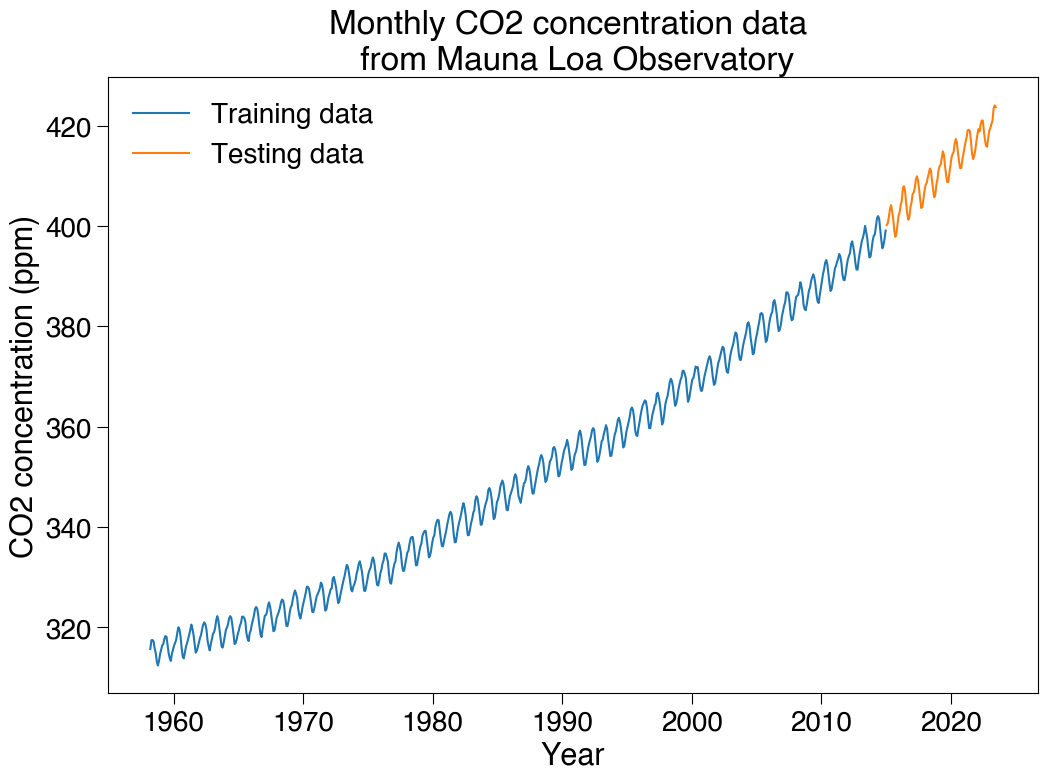

In [8]:
CO2_data = pd.read_csv('Data/co2_mm_mlo.csv',header=None)
CO2_X = torch.tensor(CO2_data.iloc[:,0].values)
CO2_y = torch.tensor(CO2_data.iloc[:,1].values)
train_X = CO2_X[CO2_X<2015]
train_y = CO2_y[CO2_X<2015]
test_X = CO2_X[CO2_X>=2015]
test_y = CO2_y[CO2_X>=2015]
plt.figure(figsize=(12,8))
plt.plot(train_X,train_y,label='Training data')
plt.plot(test_X,test_y,label='Testing data')
plt.legend()
plt.xlabel('Year')
plt.ylabel('CO2 concentration (ppm)')
plt.title('Monthly CO2 concentration data \n from Mauna Loa Observatory');

You can see that we have monthly atmospheric CO2 concentration data from 1958 to 2023. To make it more interesting, we will use data from 1958 to 2015 to train the GP model (i.e., training data) and then use data from 2015 to 2023 to see whether this model can predict the CO2 variation between 2015 and 2023 without seeing the data (i.e., testing data). 

**Kernel design**

To design the kernel to use with our Gaussian process, we can make some assumption regarding the data at hand. We observe that they have several characteristics: we see a long term rising trend, a seasonal variation and some smaller irregularities. We can use different appropriate kernel that would capture these features:

1. Long-term trend: 52 Matérn kernel. We can represent the long term trend by a 52 Matérn kernel since we can expect which to be relatively smooth. 

1. Seasonal variability: Periodic kernel. A periodic kernel is used to reflect the seasonal trend.

1. Small irregularities: Whitenoise kernel, which can be written as :$k_{Whitenoise}(t,t') = \sigma^2 \delta(t,t')$, where $\delta$ is a Dirac delta function and $\sigma$ is an amplitude hyperparameter. It can add some identically distributed noise to capture small irregularities. 

To combine them, we multiply long-term trend with seasonal variability and add which with whitenoise kernel.

One last thing to bear in mind is that, we can set prior distribution to our kernel parameters in order to reflect our prior knowledge to the fianl results. In this case, we can set a informative prior to the periodcity parameter as we know the seasonal trend should have roughly 1-year period. And for the others, we can use non-informative prior to let the data to constrain the model for us.

  0%|          | 0/1500 [00:00<?, ?it/s]

Execution time: 49.645 s


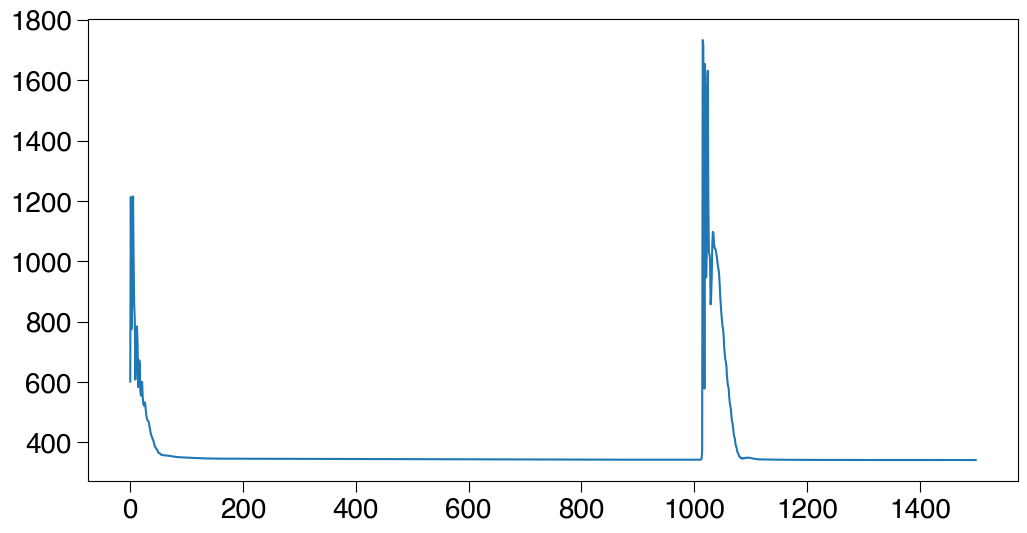

In [10]:
st = time.time() 

pyro.clear_param_store()

#create a periodic kernel
P_kernel = PSTHM.kernels.Periodic(input_dim=1)
P_kernel.set_prior("variance", dist.Uniform(torch.tensor(0.01),torch.tensor(1000.)))
P_kernel.set_prior("period", dist.Normal(torch.tensor(1.),torch.tensor(0.05)))
P_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(1.),torch.tensor(50.)))

M52_kernel = PSTHM.kernels.Matern52(input_dim=1,lengthscale=torch.tensor(1.),variance=torch.tensor(1.))
M52_kernel.set_prior('variance',dist.Uniform(torch.tensor(0.01),torch.tensor(1000.)))
M52_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(1.),torch.tensor(50.)))

#whitenoise kernel
WN_kernel = PSTHM.kernels.WhiteNoise(input_dim=1,variance=torch.tensor(1.))
WN_kernel.set_prior('variance',dist.Uniform(torch.tensor(0.01),torch.tensor(1.)))

P_combined = PSTHM.kernels.Product(P_kernel,M52_kernel)
combined_kernel = PSTHM.kernels.Sum(P_combined, WN_kernel)

gpr = PSTHM.model.GPRegression_V(train_X, train_y, combined_kernel,jitter=1e-5)

#Empirical bayes optimization 
gpr,track_list = PSTHM.opti.SVI_optm(gpr,num_iteration=1500,lr=0.05)

plt.plot(track_list['loss'])
et = time.time() # get the end time

# get the execution time
elapsed_time = et - st
print('Execution time: {:3.3f} s'.format( elapsed_time))

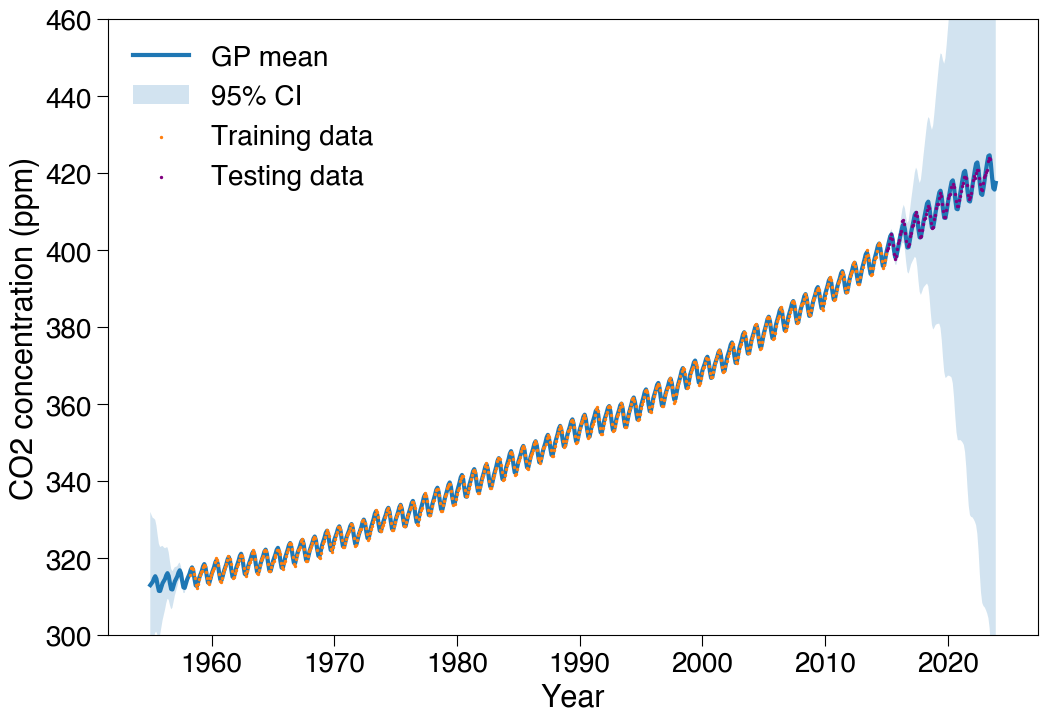

In [11]:
test_x = torch.arange(1955,2024,0.1).double()
CO2mean,CO2cov = gpr(test_x, full_cov=True,)
CO2_sd = torch.diag(CO2cov).sqrt()  
plt.figure(figsize=(12,8))
plt.plot(test_x.detach().numpy(),CO2mean.detach().numpy(),lw=3,label='GP mean ')
plt.fill_between(test_x.detach().numpy(),CO2mean.detach().numpy()-2*CO2_sd.detach().numpy(),
                    CO2mean.detach().numpy()+2*CO2_sd.detach().numpy(),alpha=0.2,label='95% CI')
plt.scatter(train_X,train_y,zorder=10,s=2,label='Training data')
plt.scatter(test_X,test_y,zorder=10,s=2,label='Testing data',color='purple')
plt.legend()
plt.ylim(300,460)
plt.xlabel('Year')
plt.ylabel('CO2 concentration (ppm)');

You can see that our GP model does a fairly good job in modelling the CO2 trend after 2015, although the confidence interval seems a bit too high, which can be fine-tuned with hyperparameter prior distributions and kernel design. If you are interested in modelling CO2 with more advanced GP kernel design, you can check this [tutorial](https://www.pymc.io/projects/docs/en/v3/pymc-examples/examples/gaussian_processes/GP-MaunaLoa.html). 

You should now familiar with some popular GP kernels and how to combine different kernels. And so far, we assume no temporal uncertainty in this tutorial, but which is not the case for most of paleo-environmental studies. So in next tutorial, we will go through two commonly-used method to deal with temporal uncertainty. 


Thanks for going through this tutorial, we are actively developing PaleoSTeHM now, so your feedback will be truely valueable to us. You can fill this [survey](https://forms.gle/W1DMPQY8KyAgoT9r6) to let us know what do you think about this tutorial, which will shape the future direction of PaleoSTeHM.